
## Super Resolution CNN 的实验

部分代码来自repo https://github.com/tegg89/SRCNN-Tensorflow

论文 http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html

In [1]:
import io
import re
import math
import zipfile
from collections import OrderedDict

from PIL import Image
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from IPython.display import display
from scipy.misc import imresize
from sklearn.model_selection import train_test_split

In [2]:
print(tf.__version__)

0.12.0


In [3]:
tf.set_random_seed(0)

In [4]:
def extract_images_bytes(path='../CatDog/train.zip', scale=0.5):
    X_data, y_data = [], []
    # load origin
    z = zipfile.ZipFile(path, 'r')
    for file in z.filelist:
        m = re.match('.*(cat|dog).*', file.filename)
        if m:
            category = m.groups()[0]
            if category != 'cat': continue
            label = re.sub('[^/]+/', '', file.filename)
            img = Image.open(io.BytesIO((z.open(file.filename).read())))
            img_label = np.array(img)
            # 先缩小，再扩大，相当于把图片有损了
            img_64 = imresize(img_label, scale, interp='bicubic')
            img_128 = imresize(img_64, 1.0 / scale, interp='bicubic')
            # 计算后的图
            X_data.append(img_128)
            y_data.append(img_label)
            if len(X_data) >= 128: break
    return np.array(X_data), np.array(y_data)

In [5]:
X_data, y_data = extract_images_bytes()

In [6]:
print(X_data.shape, y_data.shape)

(128, 128, 128, 3) (128, 128, 128, 3)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.5, random_state=0)

In [8]:
def psnr(img1, img2):
    """Peak Signal to Noise Ratio 计算图片的噪音"""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [9]:
# 输入和输出的噪音
print(psnr(X_train[0], y_train[0]))

33.3014045611457


In [10]:
# 图片自己和自己的噪音
print(psnr(y_train[0], y_train[0]))

100


In [11]:
mean_of_train = np.mean(X_train)
std_of_train = np.std(X_train)
print(mean_of_train, std_of_train)

111.27829965 66.2621584746


In [12]:
X_train = (X_train - mean_of_train) / std_of_train
X_test = (X_test - mean_of_train) / std_of_train
y_train = (y_train - mean_of_train) / std_of_train
y_test = (y_test - mean_of_train) / std_of_train

In [13]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(64, 128, 128, 3) (64, 128, 128, 3) (64, 128, 128, 3) (64, 128, 128, 3)


In [14]:
batch_size = 64
learning_rate = 0.0001
leakiness = 0.0

In [15]:
tf.set_random_seed(0)

In [16]:
X = tf.placeholder(tf.float32, [batch_size, X_train.shape[1], X_train.shape[2], 3], name='X')
y = tf.placeholder(tf.float32, [batch_size, y_train.shape[1], y_train.shape[2], 3], name='y')

In [17]:
def conv(input_layer, output_size, pitch_shape, name, strides=[1, 1, 1, 1], padding='VALID'):
    with tf.variable_scope(name):
        shape = [
            pitch_shape[0],
            pitch_shape[1],
            int(input_layer.get_shape()[-1]),
            output_size
        ]
        kernel = tf.Variable(tf.random_normal(shape, stddev=np.sqrt(2.0 / (shape[0] + shape[1] + shape[3]))))
        bias = tf.Variable(tf.zeros([shape[-1]]))
        conv = tf.nn.conv2d(input_layer, kernel, strides=strides, padding=padding)
        conv = tf.nn.bias_add(conv, bias)
        print(name, conv.get_shape())
        return conv

In [18]:
def conv_with_bn(input_layer, output_size, pitch_shape, name, strides=[1, 1, 1, 1], padding='VALID', epsilon=1e-3):
    with tf.variable_scope(name):
        shape = [
            pitch_shape[0],
            pitch_shape[1],
            int(input_layer.get_shape()[-1]),
            output_size
        ]
        kernel = tf.Variable(tf.random_normal(shape, stddev=np.sqrt(2.0 / (shape[0] + shape[1] + shape[3]))))
        beta = tf.Variable(tf.zeros([shape[-1]]))
        scale = tf.Variable(tf.zeros([shape[-1]]))
        z = tf.nn.conv2d(
            input_layer, kernel, strides=strides, padding=padding
        )
        batch_mean, batch_var = tf.nn.moments(z, [0])
        conv_bn = tf.nn.batch_normalization(
            z,
            batch_mean, batch_var,
            beta, scale,
            epsilon
        )
        print(name, conv_bn.get_shape())
        return conv_bn

In [19]:
def relu(x, leakiness=0.0):
    """Relu, with optional leaky support.
    borrow from https://github.com/tensorflow/models/blob/master/resnet/resnet_main.py
    """
    return tf.select(tf.less(x, 0.0), leakiness * x, x, name='leaky_relu')

In [20]:
model = X
print(model.get_shape())

(64, 128, 128, 3)


In [21]:
# 输入图片填充 0 ，使得经过三次卷积之后回复128x128大小
model = tf.pad(model, [[0, 0], [6, 6], [6, 6], [0, 0]])
print(model.get_shape())

(64, 140, 140, 3)


In [22]:
model = relu(conv(model, 64, (9, 9), 'conv_1', padding='VALID'), leakiness=leakiness)

conv_1 (64, 132, 132, 64)


In [23]:
model = relu(conv(model, 32, (1, 1), 'conv_2', padding='VALID'), leakiness=leakiness)

conv_2 (64, 132, 132, 32)


In [24]:
model = conv(model, 3, (5, 5), 'conv_3', padding='VALID')

conv_3 (64, 128, 128, 3)


In [25]:
pred = model

In [26]:
cost = tf.reduce_mean(tf.square(y - pred))

In [27]:
opt = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [28]:
params = tf.trainable_variables()

In [29]:
gradients = tf.gradients(cost, params)

In [30]:
clipped_gradients, norm = tf.clip_by_global_norm(
    gradients,
    5.0
)

In [31]:
train_step = opt.apply_gradients(zip(clipped_gradients, params))

In [32]:
init = tf.global_variables_initializer()

In [33]:
def batch_flow(inputs, targets, batch_size):
    """流动数据流"""
    flowed = 0
    total = len(inputs)
    while True:
        X_ret = []
        y_ret = []
        for i in range(total):
            X_ret.append(inputs[i])
            y_ret.append(targets[i])
            if len(X_ret) == batch_size:
                flowed += batch_size
                X, y = np.array(X_ret), np.array(y_ret)
                yield X, y
                X_ret = []
                y_ret = []
            if flowed >= total:
                break
        if flowed >= total:
            break

In [34]:
for batch_x, batch_y in batch_flow(X_train, y_train, batch_size):
    print(batch_x.shape, batch_y.shape)
    break

(64, 128, 128, 3) (64, 128, 128, 3)


In [35]:
n_epoch = 100000

In [37]:
tf.set_random_seed(0)
with tf.Session() as sess:
    sess.run(init)
    total = None
    for epoch in tqdm(list(range(n_epoch))):
        costs = []
        for batch_x, batch_y in batch_flow(X_train, y_train, batch_size):
            _, c = sess.run([train_step, cost], feed_dict={X: batch_x, y: batch_y})
            costs.append(c)
        if total is None:
            total = len(costs)
        if epoch > 0 and epoch % 200 == 0:
            print('epoch: {}, loss: {:.4f}'.format(epoch, np.mean(costs)))
        if epoch > 0 and epoch % 1000 == 0:
            print('calculate train accuracy')
            costs = []
            train_result = []
            for batch_x, batch_y in batch_flow(X_train, y_train, batch_size):
                c, p = sess.run([cost, pred], feed_dict={X: batch_x, y: batch_y})
                costs.append(c)
                train_result += list(p)
            print('test loss: {:.4f}'.format(np.mean(costs)))
            print('calculate test accuracy')
            costs = []
            test_result = []
            for batch_x, batch_y in batch_flow(X_test, y_test, batch_size):
                c, p = sess.run([cost, pred], feed_dict={X: batch_x, y: batch_y})
                costs.append(c)
                test_result += list(p)
            print('test loss: {:.4f}'.format(np.mean(costs)))
    print('Done')

  0%|          | 201/100000 [00:50<6:46:45,  4.09it/s]   | 1/100000 [00:01<32:05:25,  1.16s/it]

epoch: 200, loss: 3.3614


  0%|          | 401/100000 [01:43<7:06:33,  3.89it/s]  0%|          | 203/100000 [00:51<6:50:36,  4.05it/s]

epoch: 400, loss: 0.8089


  1%|          | 601/100000 [02:33<7:04:09,  3.91it/s]  0%|          | 403/100000 [01:43<7:07:52,  3.88it/s]

epoch: 600, loss: 0.3866


  1%|          | 801/100000 [03:27<7:17:13,  3.78it/s]  1%|          | 603/100000 [02:34<7:10:06,  3.85it/s]

epoch: 800, loss: 0.2653


  1%|          | 1001/100000 [04:19<8:08:47,  3.38it/s] 1%|          | 803/100000 [03:27<7:18:24,  3.77it/s]

epoch: 1000, loss: 0.2077
calculate train accuracy
test loss: 0.2075
calculate test accuracy
test loss: 0.2172


  1%|          | 1201/100000 [05:09<6:50:24,  4.01it/s]  1%|          | 1003/100000 [04:19<7:33:15,  3.64it/s]

epoch: 1200, loss: 0.1733


  1%|▏         | 1401/100000 [05:59<6:51:53,  3.99it/s]  1%|          | 1203/100000 [05:09<6:49:05,  4.03it/s]

epoch: 1400, loss: 0.1498


  2%|▏         | 1601/100000 [06:48<6:30:28,  4.20it/s]  1%|▏         | 1403/100000 [06:00<7:08:08,  3.84it/s]

epoch: 1600, loss: 0.1332


  2%|▏         | 1801/100000 [07:35<6:27:19,  4.23it/s]  2%|▏         | 1603/100000 [06:48<6:45:19,  4.05it/s]

epoch: 1800, loss: 0.1210


  2%|▏         | 2001/100000 [08:23<7:41:09,  3.54it/s]  2%|▏         | 1803/100000 [07:36<6:24:32,  4.26it/s]

epoch: 2000, loss: 0.1106
calculate train accuracy
test loss: 0.1106
calculate test accuracy
test loss: 0.1150


  2%|▏         | 2201/100000 [09:10<6:44:14,  4.03it/s]  2%|▏         | 2003/100000 [08:23<7:11:52,  3.78it/s]

epoch: 2200, loss: 0.1018


  2%|▏         | 2401/100000 [09:57<6:25:20,  4.22it/s]  2%|▏         | 2203/100000 [09:11<6:31:42,  4.16it/s]

epoch: 2400, loss: 0.0946


  3%|▎         | 2601/100000 [10:45<6:24:27,  4.22it/s]  2%|▏         | 2403/100000 [09:58<6:22:53,  4.25it/s]

epoch: 2600, loss: 0.0885


  3%|▎         | 2801/100000 [11:33<6:19:57,  4.26it/s]  3%|▎         | 2603/100000 [10:45<6:21:48,  4.25it/s]

epoch: 2800, loss: 0.0833


  3%|▎         | 3001/100000 [12:20<7:50:31,  3.44it/s]  3%|▎         | 2803/100000 [11:33<6:46:33,  3.98it/s]

epoch: 3000, loss: 0.0789
calculate train accuracy
test loss: 0.0789
calculate test accuracy
test loss: 0.0830


  3%|▎         | 3201/100000 [13:08<6:24:02,  4.20it/s]  3%|▎         | 3003/100000 [12:21<7:04:33,  3.81it/s]

epoch: 3200, loss: 0.0750


  3%|▎         | 3401/100000 [13:56<6:34:29,  4.08it/s]  3%|▎         | 3203/100000 [13:09<6:40:08,  4.03it/s]

epoch: 3400, loss: 0.0714


  4%|▎         | 3601/100000 [14:44<6:29:30,  4.12it/s]  3%|▎         | 3403/100000 [13:57<6:26:27,  4.17it/s]

epoch: 3600, loss: 0.0681


  4%|▍         | 3801/100000 [15:32<6:14:04,  4.29it/s]  4%|▎         | 3603/100000 [14:44<6:24:03,  4.18it/s]

epoch: 3800, loss: 0.0652


  4%|▍         | 4001/100000 [16:20<7:18:37,  3.65it/s]  4%|▍         | 3803/100000 [15:32<6:33:26,  4.08it/s]

epoch: 4000, loss: 0.0623
calculate train accuracy
test loss: 0.0623
calculate test accuracy
test loss: 0.0665


  4%|▍         | 4201/100000 [17:07<6:24:53,  4.15it/s]  4%|▍         | 4003/100000 [16:20<6:45:55,  3.94it/s]

epoch: 4200, loss: 0.0601


  4%|▍         | 4401/100000 [17:55<6:11:01,  4.29it/s]  4%|▍         | 4203/100000 [17:08<6:22:25,  4.18it/s]

epoch: 4400, loss: 0.0577


  5%|▍         | 4601/100000 [18:43<6:06:09,  4.34it/s]  4%|▍         | 4403/100000 [17:56<6:42:52,  3.95it/s]

epoch: 4600, loss: 0.0556


  5%|▍         | 4801/100000 [19:31<6:09:28,  4.29it/s]  5%|▍         | 4603/100000 [18:44<6:11:26,  4.28it/s]

epoch: 4800, loss: 0.0538


  5%|▌         | 5001/100000 [20:19<7:22:26,  3.58it/s]  5%|▍         | 4803/100000 [19:31<6:27:38,  4.09it/s]

epoch: 5000, loss: 0.0514
calculate train accuracy
test loss: 0.0514
calculate test accuracy
test loss: 0.0554


  5%|▌         | 5201/100000 [21:07<6:17:44,  4.18it/s]  5%|▌         | 5003/100000 [20:19<6:57:05,  3.80it/s]

epoch: 5200, loss: 0.0497


  5%|▌         | 5401/100000 [21:55<6:09:44,  4.26it/s]  5%|▌         | 5203/100000 [21:07<6:14:05,  4.22it/s]

epoch: 5400, loss: 0.0479


  6%|▌         | 5601/100000 [22:42<6:14:52,  4.20it/s]  5%|▌         | 5403/100000 [21:55<6:39:33,  3.95it/s]

epoch: 5600, loss: 0.0463


  6%|▌         | 5801/100000 [23:30<6:02:43,  4.33it/s]  6%|▌         | 5603/100000 [22:43<6:35:00,  3.98it/s]

epoch: 5800, loss: 0.0450


  6%|▌         | 6001/100000 [24:18<7:08:55,  3.65it/s]  6%|▌         | 5803/100000 [23:30<6:04:50,  4.30it/s]

epoch: 6000, loss: 0.0433
calculate train accuracy
test loss: 0.0433
calculate test accuracy
test loss: 0.0470


  6%|▌         | 6201/100000 [25:05<6:10:47,  4.22it/s]  6%|▌         | 6003/100000 [24:18<6:37:01,  3.95it/s]

epoch: 6200, loss: 0.0419


  6%|▋         | 6401/100000 [25:53<6:20:50,  4.10it/s]  6%|▌         | 6203/100000 [25:06<6:08:33,  4.24it/s]

epoch: 6400, loss: 0.0406


  7%|▋         | 6601/100000 [26:41<5:58:19,  4.34it/s]  6%|▋         | 6403/100000 [25:54<6:21:08,  4.09it/s]

epoch: 6600, loss: 0.0395


  7%|▋         | 6801/100000 [27:29<6:10:46,  4.19it/s]  7%|▋         | 6603/100000 [26:42<6:01:53,  4.30it/s]

epoch: 6800, loss: 0.0381


  7%|▋         | 7001/100000 [28:17<7:29:16,  3.45it/s]  7%|▋         | 6803/100000 [27:29<6:08:00,  4.22it/s]

epoch: 7000, loss: 0.0369
calculate train accuracy
test loss: 0.0369
calculate test accuracy
test loss: 0.0403


  7%|▋         | 7201/100000 [29:05<6:19:15,  4.08it/s]  7%|▋         | 7003/100000 [28:17<6:46:22,  3.81it/s]

epoch: 7200, loss: 0.0372


  7%|▋         | 7401/100000 [29:53<6:00:06,  4.29it/s]  7%|▋         | 7203/100000 [29:05<6:26:57,  4.00it/s]

epoch: 7400, loss: 0.0347


  8%|▊         | 7601/100000 [30:41<6:20:12,  4.05it/s]  7%|▋         | 7403/100000 [29:53<5:59:50,  4.29it/s]

epoch: 7600, loss: 0.0336


  8%|▊         | 7801/100000 [31:29<6:13:10,  4.12it/s]  8%|▊         | 7603/100000 [30:41<6:10:16,  4.16it/s]

epoch: 7800, loss: 0.0326


  8%|▊         | 8001/100000 [32:16<7:19:25,  3.49it/s]  8%|▊         | 7803/100000 [31:29<6:05:57,  4.20it/s]

epoch: 8000, loss: 0.0317
calculate train accuracy
test loss: 0.0317
calculate test accuracy
test loss: 0.0348


  8%|▊         | 8201/100000 [33:04<6:03:36,  4.21it/s]  8%|▊         | 8003/100000 [32:17<6:40:08,  3.83it/s]

epoch: 8200, loss: 0.0307


  8%|▊         | 8401/100000 [33:52<6:06:18,  4.17it/s]  8%|▊         | 8203/100000 [33:04<6:09:45,  4.14it/s]

epoch: 8400, loss: 0.0299


  9%|▊         | 8601/100000 [34:40<6:01:15,  4.22it/s]  8%|▊         | 8403/100000 [33:52<6:01:10,  4.23it/s]

epoch: 8600, loss: 0.0291


  9%|▉         | 8801/100000 [35:28<5:55:54,  4.27it/s]  9%|▊         | 8603/100000 [34:40<6:09:21,  4.12it/s]

epoch: 8800, loss: 0.0283


  9%|▉         | 9001/100000 [36:16<6:59:19,  3.62it/s]  9%|▉         | 8803/100000 [35:28<5:54:57,  4.28it/s]

epoch: 9000, loss: 0.0275
calculate train accuracy
test loss: 0.0275
calculate test accuracy
test loss: 0.0301


  9%|▉         | 9201/100000 [37:03<5:59:18,  4.21it/s]  9%|▉         | 9003/100000 [36:16<6:39:24,  3.80it/s]

epoch: 9200, loss: 0.0268


  9%|▉         | 9401/100000 [37:51<6:10:48,  4.07it/s]  9%|▉         | 9203/100000 [37:04<6:05:29,  4.14it/s]

epoch: 9400, loss: 0.0262


 10%|▉         | 9601/100000 [38:40<6:02:05,  4.16it/s]  9%|▉         | 9403/100000 [37:52<6:14:57,  4.03it/s]

epoch: 9600, loss: 0.0256


 10%|▉         | 9801/100000 [39:27<5:48:05,  4.32it/s] 10%|▉         | 9603/100000 [38:40<6:23:21,  3.93it/s]

epoch: 9800, loss: 0.0250


 10%|█         | 10001/100000 [40:16<6:56:36,  3.60it/s]10%|▉         | 9803/100000 [39:28<5:52:55,  4.26it/s]

epoch: 10000, loss: 0.0245
calculate train accuracy
test loss: 0.0245
calculate test accuracy
test loss: 0.0265


 10%|█         | 10201/100000 [41:03<6:08:47,  4.06it/s] 10%|█         | 10003/100000 [40:16<6:22:55,  3.92it/s]

epoch: 10200, loss: 0.0240


 10%|█         | 10401/100000 [41:51<6:15:52,  3.97it/s] 10%|█         | 10203/100000 [41:04<6:10:36,  4.04it/s]

epoch: 10400, loss: 0.0237


 11%|█         | 10601/100000 [42:40<5:44:52,  4.32it/s] 10%|█         | 10403/100000 [41:52<6:28:35,  3.84it/s]

epoch: 10600, loss: 0.0232


 11%|█         | 10801/100000 [43:27<5:47:58,  4.27it/s] 11%|█         | 10603/100000 [42:40<6:03:49,  4.10it/s]

epoch: 10800, loss: 0.0228


 11%|█         | 11001/100000 [44:15<6:48:16,  3.63it/s] 11%|█         | 10803/100000 [43:28<5:48:16,  4.27it/s]

epoch: 11000, loss: 0.0225
calculate train accuracy
test loss: 0.0225
calculate test accuracy
test loss: 0.0240


 11%|█         | 11201/100000 [45:03<5:48:18,  4.25it/s] 11%|█         | 11003/100000 [44:15<6:34:32,  3.76it/s]

epoch: 11200, loss: 0.0221


 11%|█▏        | 11401/100000 [45:50<5:40:27,  4.34it/s] 11%|█         | 11203/100000 [45:03<5:47:59,  4.25it/s]

epoch: 11400, loss: 0.0219


 12%|█▏        | 11601/100000 [46:38<5:40:44,  4.32it/s] 11%|█▏        | 11403/100000 [45:51<5:44:02,  4.29it/s]

epoch: 11600, loss: 0.0215


 12%|█▏        | 11801/100000 [47:26<5:39:13,  4.33it/s] 12%|█▏        | 11603/100000 [46:39<5:52:50,  4.18it/s]

epoch: 11800, loss: 0.0213


 12%|█▏        | 12001/100000 [48:14<6:52:25,  3.56it/s] 12%|█▏        | 11803/100000 [47:26<5:57:28,  4.11it/s]

epoch: 12000, loss: 0.0208
calculate train accuracy
test loss: 0.0208
calculate test accuracy
test loss: 0.0218


 12%|█▏        | 12201/100000 [49:02<6:00:06,  4.06it/s] 12%|█▏        | 12003/100000 [48:15<6:37:33,  3.69it/s]

epoch: 12200, loss: 0.0203


 12%|█▏        | 12401/100000 [49:50<5:41:19,  4.28it/s] 12%|█▏        | 12203/100000 [49:02<5:52:55,  4.15it/s]

epoch: 12400, loss: 0.0197


 13%|█▎        | 12601/100000 [50:38<5:37:21,  4.32it/s] 12%|█▏        | 12403/100000 [49:50<5:42:43,  4.26it/s]

epoch: 12600, loss: 0.0192


 13%|█▎        | 12801/100000 [51:25<5:57:19,  4.07it/s] 13%|█▎        | 12603/100000 [50:38<5:39:02,  4.30it/s]

epoch: 12800, loss: 0.0188


 13%|█▎        | 13001/100000 [52:14<7:10:57,  3.36it/s] 13%|█▎        | 12803/100000 [51:26<6:05:51,  3.97it/s]

epoch: 13000, loss: 0.0185
calculate train accuracy
test loss: 0.0185
calculate test accuracy
test loss: 0.0189


 13%|█▎        | 13201/100000 [53:01<5:33:04,  4.34it/s] 13%|█▎        | 13003/100000 [52:14<6:31:01,  3.71it/s]

epoch: 13200, loss: 0.0182


 13%|█▎        | 13401/100000 [53:49<5:34:45,  4.31it/s] 13%|█▎        | 13203/100000 [53:02<5:46:39,  4.17it/s]

epoch: 13400, loss: 0.0180


 14%|█▎        | 13601/100000 [54:37<5:32:29,  4.33it/s] 13%|█▎        | 13403/100000 [53:50<5:35:57,  4.30it/s]

epoch: 13600, loss: 0.0178


 14%|█▍        | 13801/100000 [55:25<5:43:22,  4.18it/s] 14%|█▎        | 13603/100000 [54:38<5:34:31,  4.30it/s]

epoch: 13800, loss: 0.0175


 14%|█▍        | 14001/100000 [56:13<6:58:51,  3.42it/s] 14%|█▍        | 13803/100000 [55:26<5:40:45,  4.22it/s]

epoch: 14000, loss: 0.0173
calculate train accuracy
test loss: 0.0174
calculate test accuracy
test loss: 0.0167


 14%|█▍        | 14201/100000 [57:01<5:32:46,  4.30it/s] 14%|█▍        | 14003/100000 [56:14<6:35:23,  3.63it/s]

epoch: 14200, loss: 0.0170


 14%|█▍        | 14401/100000 [57:49<5:32:04,  4.30it/s] 14%|█▍        | 14203/100000 [57:02<5:35:14,  4.27it/s]

epoch: 14400, loss: 0.0168


 15%|█▍        | 14601/100000 [58:37<5:46:17,  4.11it/s] 14%|█▍        | 14403/100000 [57:49<5:33:08,  4.28it/s]

epoch: 14600, loss: 0.0166


 15%|█▍        | 14801/100000 [59:25<5:48:02,  4.08it/s] 15%|█▍        | 14603/100000 [58:37<6:03:41,  3.91it/s]

epoch: 14800, loss: 0.0165


 15%|█▌        | 15001/100000 [1:00:13<6:32:52,  3.61it/s]5%|█▍        | 14803/100000 [59:25<5:41:02,  4.16it/s]

epoch: 15000, loss: 0.0162
calculate train accuracy
test loss: 0.0162
calculate test accuracy
test loss: 0.0158


 15%|█▌        | 15201/100000 [1:01:01<5:29:04,  4.29it/s] 15%|█▌        | 15003/100000 [1:00:13<6:02:15,  3.91it/s]

epoch: 15200, loss: 0.0161


 15%|█▌        | 15401/100000 [1:01:48<5:30:23,  4.27it/s] 15%|█▌        | 15203/100000 [1:01:01<5:29:25,  4.29it/s]

epoch: 15400, loss: 0.0160


 16%|█▌        | 15601/100000 [1:02:36<5:25:10,  4.33it/s] 15%|█▌        | 15403/100000 [1:01:49<5:29:56,  4.27it/s]

epoch: 15600, loss: 0.0158


 16%|█▌        | 15801/100000 [1:03:24<5:46:49,  4.05it/s] 16%|█▌        | 15603/100000 [1:02:36<5:32:33,  4.23it/s]

epoch: 15800, loss: 0.0159


 16%|█▌        | 16001/100000 [1:04:12<6:27:26,  3.61it/s] 16%|█▌        | 15803/100000 [1:03:24<5:42:47,  4.09it/s]

epoch: 16000, loss: 0.0156
calculate train accuracy
test loss: 0.0156
calculate test accuracy
test loss: 0.0151


 16%|█▌        | 16201/100000 [1:05:00<5:38:43,  4.12it/s] 16%|█▌        | 16003/100000 [1:04:12<6:12:53,  3.75it/s]

epoch: 16200, loss: 0.0155


 16%|█▋        | 16401/100000 [1:05:47<5:37:05,  4.13it/s] 16%|█▌        | 16203/100000 [1:05:00<5:49:47,  3.99it/s]

epoch: 16400, loss: 0.0154


 17%|█▋        | 16601/100000 [1:06:35<5:39:57,  4.09it/s] 16%|█▋        | 16403/100000 [1:05:48<5:32:24,  4.19it/s]

epoch: 16600, loss: 0.0153


 17%|█▋        | 16801/100000 [1:07:23<5:21:08,  4.32it/s] 17%|█▋        | 16603/100000 [1:06:35<5:32:51,  4.18it/s]

epoch: 16800, loss: 0.0153


 17%|█▋        | 17001/100000 [1:08:11<6:21:20,  3.63it/s] 17%|█▋        | 16803/100000 [1:07:23<5:25:21,  4.26it/s]

epoch: 17000, loss: 0.0151
calculate train accuracy
test loss: 0.0151
calculate test accuracy
test loss: 0.0147


 17%|█▋        | 17201/100000 [1:08:59<5:22:44,  4.28it/s] 17%|█▋        | 17003/100000 [1:08:11<6:08:30,  3.75it/s]

epoch: 17200, loss: 0.0152


 17%|█▋        | 17401/100000 [1:09:46<5:17:45,  4.33it/s] 17%|█▋        | 17203/100000 [1:08:59<5:24:19,  4.25it/s]

epoch: 17400, loss: 0.0151


 18%|█▊        | 17601/100000 [1:10:34<5:31:11,  4.15it/s] 17%|█▋        | 17403/100000 [1:09:47<5:31:32,  4.15it/s]

epoch: 17600, loss: 0.0149


 18%|█▊        | 17801/100000 [1:11:22<5:39:43,  4.03it/s] 18%|█▊        | 17603/100000 [1:10:35<5:26:21,  4.21it/s]

epoch: 17800, loss: 0.0148


 18%|█▊        | 18001/100000 [1:12:10<6:31:50,  3.49it/s] 18%|█▊        | 17803/100000 [1:11:23<5:30:32,  4.14it/s]

epoch: 18000, loss: 0.0148
calculate train accuracy
test loss: 0.0148
calculate test accuracy
test loss: 0.0144


 18%|█▊        | 18201/100000 [1:12:57<5:37:14,  4.04it/s] 18%|█▊        | 18003/100000 [1:12:10<5:55:01,  3.85it/s]

epoch: 18200, loss: 0.0147


 18%|█▊        | 18401/100000 [1:13:45<5:30:54,  4.11it/s] 18%|█▊        | 18203/100000 [1:12:58<5:28:24,  4.15it/s]

epoch: 18400, loss: 0.0147


 19%|█▊        | 18601/100000 [1:14:33<5:30:03,  4.11it/s] 18%|█▊        | 18403/100000 [1:13:45<5:25:04,  4.18it/s]

epoch: 18600, loss: 0.0147


 19%|█▉        | 18801/100000 [1:15:21<5:25:24,  4.16it/s] 19%|█▊        | 18603/100000 [1:14:33<5:38:55,  4.00it/s]

epoch: 18800, loss: 0.0145


 19%|█▉        | 19001/100000 [1:16:09<6:09:53,  3.65it/s] 19%|█▉        | 18803/100000 [1:15:21<5:21:07,  4.21it/s]

epoch: 19000, loss: 0.0146
calculate train accuracy
test loss: 0.0146
calculate test accuracy
test loss: 0.0143


 19%|█▉        | 19201/100000 [1:16:56<5:17:37,  4.24it/s] 19%|█▉        | 19003/100000 [1:16:09<5:58:10,  3.77it/s]

epoch: 19200, loss: 0.0144


 19%|█▉        | 19401/100000 [1:17:44<5:46:00,  3.88it/s] 19%|█▉        | 19203/100000 [1:16:57<5:16:17,  4.26it/s]

epoch: 19400, loss: 0.0143


 20%|█▉        | 19601/100000 [1:18:32<5:10:26,  4.32it/s] 19%|█▉        | 19403/100000 [1:17:45<5:38:21,  3.97it/s]

epoch: 19600, loss: 0.0143


 20%|█▉        | 19801/100000 [1:19:20<5:10:37,  4.30it/s] 20%|█▉        | 19603/100000 [1:18:33<5:25:10,  4.12it/s]

epoch: 19800, loss: 0.0142


 20%|██        | 20001/100000 [1:20:08<6:29:06,  3.43it/s] 20%|█▉        | 19803/100000 [1:19:20<5:12:33,  4.28it/s]

epoch: 20000, loss: 0.0142
calculate train accuracy
test loss: 0.0142
calculate test accuracy
test loss: 0.0140


 20%|██        | 20201/100000 [1:20:55<5:11:03,  4.28it/s] 20%|██        | 20003/100000 [1:20:09<5:51:25,  3.79it/s]

epoch: 20200, loss: 0.0141


 20%|██        | 20401/100000 [1:21:43<5:06:43,  4.33it/s] 20%|██        | 20203/100000 [1:20:56<5:11:04,  4.28it/s]

epoch: 20400, loss: 0.0141


 21%|██        | 20601/100000 [1:22:31<5:15:44,  4.19it/s] 20%|██        | 20403/100000 [1:21:44<5:17:21,  4.18it/s]

epoch: 20600, loss: 0.0140


 21%|██        | 20801/100000 [1:23:19<5:07:31,  4.29it/s] 21%|██        | 20603/100000 [1:22:32<5:12:27,  4.23it/s]

epoch: 20800, loss: 0.0140


 21%|██        | 21001/100000 [1:24:07<6:27:04,  3.40it/s] 21%|██        | 20803/100000 [1:23:19<5:09:13,  4.27it/s]

epoch: 21000, loss: 0.0139
calculate train accuracy
test loss: 0.0139
calculate test accuracy
test loss: 0.0137


 21%|██        | 21201/100000 [1:24:54<5:13:19,  4.19it/s] 21%|██        | 21003/100000 [1:24:07<5:57:13,  3.69it/s]

epoch: 21200, loss: 0.0140


 21%|██▏       | 21401/100000 [1:25:42<5:02:24,  4.33it/s] 21%|██        | 21203/100000 [1:24:55<5:11:15,  4.22it/s]

epoch: 21400, loss: 0.0139


 22%|██▏       | 21601/100000 [1:26:30<5:12:53,  4.18it/s] 21%|██▏       | 21403/100000 [1:25:43<5:21:40,  4.07it/s]

epoch: 21600, loss: 0.0138


 22%|██▏       | 21801/100000 [1:27:18<5:00:47,  4.33it/s] 22%|██▏       | 21603/100000 [1:26:30<5:09:35,  4.22it/s]

epoch: 21800, loss: 0.0138


 22%|██▏       | 22001/100000 [1:28:06<6:07:58,  3.53it/s] 22%|██▏       | 21803/100000 [1:27:18<5:13:53,  4.15it/s]

epoch: 22000, loss: 0.0137
calculate train accuracy
test loss: 0.0137
calculate test accuracy
test loss: 0.0136


 22%|██▏       | 22201/100000 [1:28:54<5:15:27,  4.11it/s] 22%|██▏       | 22003/100000 [1:28:07<5:36:11,  3.87it/s]

epoch: 22200, loss: 0.0137


 22%|██▏       | 22401/100000 [1:29:42<5:06:38,  4.22it/s] 22%|██▏       | 22203/100000 [1:28:55<5:10:11,  4.18it/s]

epoch: 22400, loss: 0.0136


 23%|██▎       | 22601/100000 [1:30:30<5:06:38,  4.21it/s] 22%|██▏       | 22403/100000 [1:29:42<5:04:43,  4.24it/s]

epoch: 22600, loss: 0.0136


 23%|██▎       | 22801/100000 [1:31:17<5:11:52,  4.13it/s] 23%|██▎       | 22603/100000 [1:30:30<5:04:39,  4.23it/s]

epoch: 22800, loss: 0.0138


 23%|██▎       | 23001/100000 [1:32:06<6:01:19,  3.55it/s] 23%|██▎       | 22803/100000 [1:31:18<5:06:30,  4.20it/s]

epoch: 23000, loss: 0.0135
calculate train accuracy
test loss: 0.0135
calculate test accuracy
test loss: 0.0135


 23%|██▎       | 23201/100000 [1:32:54<5:26:18,  3.92it/s] 23%|██▎       | 23003/100000 [1:32:06<5:30:40,  3.88it/s]

epoch: 23200, loss: 0.0135


 23%|██▎       | 23401/100000 [1:33:42<4:57:42,  4.29it/s] 23%|██▎       | 23203/100000 [1:32:54<5:20:38,  3.99it/s]

epoch: 23400, loss: 0.0136


 24%|██▎       | 23601/100000 [1:34:30<5:08:29,  4.13it/s] 23%|██▎       | 23403/100000 [1:33:42<5:13:38,  4.07it/s]

epoch: 23600, loss: 0.0134


 24%|██▍       | 23801/100000 [1:35:17<4:53:55,  4.32it/s] 24%|██▎       | 23603/100000 [1:34:30<5:24:47,  3.92it/s]

epoch: 23800, loss: 0.0135


 24%|██▍       | 24001/100000 [1:36:05<5:50:18,  3.62it/s] 24%|██▍       | 23803/100000 [1:35:18<4:55:46,  4.29it/s]

epoch: 24000, loss: 0.0134
calculate train accuracy
test loss: 0.0134
calculate test accuracy
test loss: 0.0134


 24%|██▍       | 24201/100000 [1:36:53<5:15:49,  4.00it/s] 24%|██▍       | 24003/100000 [1:36:06<5:23:45,  3.91it/s]

epoch: 24200, loss: 0.0135


 24%|██▍       | 24401/100000 [1:37:41<4:51:46,  4.32it/s] 24%|██▍       | 24203/100000 [1:36:53<5:16:39,  3.99it/s]

epoch: 24400, loss: 0.0133


 25%|██▍       | 24601/100000 [1:38:28<4:49:27,  4.34it/s] 24%|██▍       | 24403/100000 [1:37:41<5:04:01,  4.14it/s]

epoch: 24600, loss: 0.0133


 25%|██▍       | 24801/100000 [1:39:16<4:51:37,  4.30it/s] 25%|██▍       | 24603/100000 [1:38:29<4:52:41,  4.29it/s]

epoch: 24800, loss: 0.0132


 25%|██▌       | 25001/100000 [1:40:04<6:08:24,  3.39it/s] 25%|██▍       | 24803/100000 [1:39:17<4:53:30,  4.27it/s]

epoch: 25000, loss: 0.0132
calculate train accuracy
test loss: 0.0132
calculate test accuracy
test loss: 0.0134


 25%|██▌       | 25201/100000 [1:40:52<4:57:33,  4.19it/s] 25%|██▌       | 25003/100000 [1:40:05<5:40:26,  3.67it/s]

epoch: 25200, loss: 0.0132


 25%|██▌       | 25401/100000 [1:41:40<4:54:07,  4.23it/s] 25%|██▌       | 25203/100000 [1:40:52<5:05:01,  4.09it/s]

epoch: 25400, loss: 0.0132


 26%|██▌       | 25601/100000 [1:42:27<5:00:49,  4.12it/s] 25%|██▌       | 25403/100000 [1:41:40<4:53:03,  4.24it/s]

epoch: 25600, loss: 0.0131


 26%|██▌       | 25801/100000 [1:43:15<4:50:49,  4.25it/s] 26%|██▌       | 25603/100000 [1:42:28<4:55:22,  4.20it/s]

epoch: 25800, loss: 0.0131


 26%|██▌       | 26001/100000 [1:44:03<5:45:02,  3.57it/s] 26%|██▌       | 25803/100000 [1:43:16<4:58:10,  4.15it/s]

epoch: 26000, loss: 0.0130
calculate train accuracy
test loss: 0.0130
calculate test accuracy
test loss: 0.0135


 26%|██▌       | 26201/100000 [1:44:51<4:50:02,  4.24it/s] 26%|██▌       | 26003/100000 [1:44:04<5:22:50,  3.82it/s]

epoch: 26200, loss: 0.0130


 26%|██▋       | 26401/100000 [1:45:39<4:56:06,  4.14it/s] 26%|██▌       | 26203/100000 [1:44:52<4:55:32,  4.16it/s]

epoch: 26400, loss: 0.0130


 27%|██▋       | 26601/100000 [1:46:27<4:48:50,  4.24it/s] 26%|██▋       | 26403/100000 [1:45:39<4:54:20,  4.17it/s]

epoch: 26600, loss: 0.0129


 27%|██▋       | 26801/100000 [1:47:15<5:00:28,  4.06it/s] 27%|██▋       | 26603/100000 [1:46:28<4:49:03,  4.23it/s]

epoch: 26800, loss: 0.0131


 27%|██▋       | 27001/100000 [1:48:03<5:41:27,  3.56it/s] 27%|██▋       | 26803/100000 [1:47:16<4:52:55,  4.16it/s]

epoch: 27000, loss: 0.0129
calculate train accuracy
test loss: 0.0129
calculate test accuracy
test loss: 0.0135


 27%|██▋       | 27201/100000 [1:48:52<4:45:14,  4.25it/s] 27%|██▋       | 27003/100000 [1:48:04<5:20:30,  3.80it/s]

epoch: 27200, loss: 0.0129


 27%|██▋       | 27401/100000 [1:49:40<4:50:08,  4.17it/s] 27%|██▋       | 27203/100000 [1:48:52<4:46:02,  4.24it/s]

epoch: 27400, loss: 0.0128


 28%|██▊       | 27601/100000 [1:50:28<4:45:36,  4.22it/s] 27%|██▋       | 27403/100000 [1:49:40<4:57:27,  4.07it/s]

epoch: 27600, loss: 0.0129


 28%|██▊       | 27801/100000 [1:51:16<4:45:55,  4.21it/s] 28%|██▊       | 27603/100000 [1:50:28<4:53:45,  4.11it/s]

epoch: 27800, loss: 0.0128


 28%|██▊       | 28001/100000 [1:52:04<5:47:32,  3.45it/s] 28%|██▊       | 27803/100000 [1:51:16<4:44:30,  4.23it/s]

epoch: 28000, loss: 0.0127
calculate train accuracy
test loss: 0.0127
calculate test accuracy
test loss: 0.0136


 28%|██▊       | 28201/100000 [1:52:52<4:42:57,  4.23it/s] 28%|██▊       | 28003/100000 [1:52:05<5:14:39,  3.81it/s]

epoch: 28200, loss: 0.0127


 28%|██▊       | 28401/100000 [1:53:40<4:38:49,  4.28it/s] 28%|██▊       | 28203/100000 [1:52:53<4:41:24,  4.25it/s]

epoch: 28400, loss: 0.0128


 29%|██▊       | 28601/100000 [1:54:28<4:36:52,  4.30it/s] 28%|██▊       | 28403/100000 [1:53:40<4:39:46,  4.27it/s]

epoch: 28600, loss: 0.0127


 29%|██▉       | 28801/100000 [1:55:15<4:39:47,  4.24it/s] 29%|██▊       | 28603/100000 [1:54:28<4:38:09,  4.28it/s]

epoch: 28800, loss: 0.0129


 29%|██▉       | 29001/100000 [1:56:03<5:26:26,  3.62it/s] 29%|██▉       | 28803/100000 [1:55:16<4:39:06,  4.25it/s]

epoch: 29000, loss: 0.0126
calculate train accuracy
test loss: 0.0126
calculate test accuracy
test loss: 0.0135


 29%|██▉       | 29201/100000 [1:56:51<4:33:14,  4.32it/s] 29%|██▉       | 29003/100000 [1:56:04<5:08:42,  3.83it/s]

epoch: 29200, loss: 0.0126


 29%|██▉       | 29401/100000 [1:57:39<4:35:27,  4.27it/s] 29%|██▉       | 29203/100000 [1:56:52<4:45:26,  4.13it/s]

epoch: 29400, loss: 0.0126


 30%|██▉       | 29601/100000 [1:58:28<4:42:36,  4.15it/s] 29%|██▉       | 29403/100000 [1:57:40<4:36:39,  4.25it/s]

epoch: 29600, loss: 0.0126


 30%|██▉       | 29801/100000 [1:59:15<4:37:51,  4.21it/s] 30%|██▉       | 29603/100000 [1:58:28<4:39:32,  4.20it/s]

epoch: 29800, loss: 0.0127


 30%|███       | 30001/100000 [2:00:03<5:27:13,  3.57it/s] 30%|██▉       | 29803/100000 [1:59:16<4:44:25,  4.11it/s]

epoch: 30000, loss: 0.0125
calculate train accuracy
test loss: 0.0125
calculate test accuracy
test loss: 0.0135


 30%|███       | 30201/100000 [2:00:51<4:34:30,  4.24it/s] 30%|███       | 30003/100000 [2:00:04<5:07:34,  3.79it/s]

epoch: 30200, loss: 0.0125


 30%|███       | 30401/100000 [2:01:39<4:35:52,  4.20it/s] 30%|███       | 30203/100000 [2:00:51<4:51:06,  4.00it/s]

epoch: 30400, loss: 0.0125


 31%|███       | 30601/100000 [2:02:27<4:39:43,  4.13it/s] 30%|███       | 30403/100000 [2:01:39<4:44:00,  4.08it/s]

epoch: 30600, loss: 0.0125


 31%|███       | 30801/100000 [2:03:15<4:34:57,  4.19it/s] 31%|███       | 30603/100000 [2:02:27<4:45:28,  4.05it/s]

epoch: 30800, loss: 0.0124


 31%|███       | 31001/100000 [2:04:03<5:18:23,  3.61it/s] 31%|███       | 30803/100000 [2:03:15<4:42:29,  4.08it/s]

epoch: 31000, loss: 0.0124
calculate train accuracy
test loss: 0.0124
calculate test accuracy
test loss: 0.0136


 31%|███       | 31201/100000 [2:04:51<4:31:22,  4.23it/s] 31%|███       | 31003/100000 [2:04:03<4:54:19,  3.91it/s]

epoch: 31200, loss: 0.0124


 31%|███▏      | 31401/100000 [2:05:39<4:34:52,  4.16it/s] 31%|███       | 31203/100000 [2:04:51<4:31:08,  4.23it/s]

epoch: 31400, loss: 0.0124


 32%|███▏      | 31601/100000 [2:06:27<4:27:30,  4.26it/s] 31%|███▏      | 31403/100000 [2:05:39<4:33:39,  4.18it/s]

epoch: 31600, loss: 0.0124


 32%|███▏      | 31801/100000 [2:07:14<4:29:30,  4.22it/s] 32%|███▏      | 31603/100000 [2:06:27<4:26:53,  4.27it/s]

epoch: 31800, loss: 0.0124


 32%|███▏      | 32001/100000 [2:08:02<5:18:18,  3.56it/s] 32%|███▏      | 31803/100000 [2:07:15<4:28:38,  4.23it/s]

epoch: 32000, loss: 0.0123
calculate train accuracy
test loss: 0.0123
calculate test accuracy
test loss: 0.0137


 32%|███▏      | 32201/100000 [2:08:50<4:32:21,  4.15it/s] 32%|███▏      | 32003/100000 [2:08:02<4:51:46,  3.88it/s]

epoch: 32200, loss: 0.0123


 32%|███▏      | 32401/100000 [2:09:37<4:29:39,  4.18it/s] 32%|███▏      | 32203/100000 [2:08:50<4:28:26,  4.21it/s]

epoch: 32400, loss: 0.0123


 33%|███▎      | 32601/100000 [2:10:25<4:32:40,  4.12it/s] 32%|███▏      | 32403/100000 [2:09:38<4:26:54,  4.22it/s]

epoch: 32600, loss: 0.0123


 33%|███▎      | 32801/100000 [2:11:13<4:35:12,  4.07it/s] 33%|███▎      | 32603/100000 [2:10:25<4:34:37,  4.09it/s]

epoch: 32800, loss: 0.0123


 33%|███▎      | 33001/100000 [2:12:01<5:20:32,  3.48it/s] 33%|███▎      | 32803/100000 [2:11:13<4:29:02,  4.16it/s]

epoch: 33000, loss: 0.0123
calculate train accuracy
test loss: 0.0123
calculate test accuracy
test loss: 0.0138


 33%|███▎      | 33201/100000 [2:12:49<4:23:08,  4.23it/s] 33%|███▎      | 33003/100000 [2:12:01<5:00:37,  3.71it/s]

epoch: 33200, loss: 0.0123


 33%|███▎      | 33401/100000 [2:13:36<4:24:41,  4.19it/s] 33%|███▎      | 33203/100000 [2:12:49<4:22:58,  4.23it/s]

epoch: 33400, loss: 0.0122


 34%|███▎      | 33601/100000 [2:14:24<4:26:34,  4.15it/s] 33%|███▎      | 33403/100000 [2:13:37<4:23:42,  4.21it/s]

epoch: 33600, loss: 0.0122


 34%|███▍      | 33801/100000 [2:15:12<4:23:51,  4.18it/s] 34%|███▎      | 33603/100000 [2:14:24<4:24:00,  4.19it/s]

epoch: 33800, loss: 0.0122


 34%|███▍      | 34001/100000 [2:15:59<5:11:18,  3.53it/s] 34%|███▍      | 33803/100000 [2:15:12<4:21:06,  4.23it/s]

epoch: 34000, loss: 0.0122
calculate train accuracy
test loss: 0.0122
calculate test accuracy
test loss: 0.0139


 34%|███▍      | 34201/100000 [2:16:47<4:26:22,  4.12it/s] 34%|███▍      | 34003/100000 [2:16:00<4:53:38,  3.75it/s]

epoch: 34200, loss: 0.0122


 34%|███▍      | 34401/100000 [2:17:35<4:14:00,  4.30it/s] 34%|███▍      | 34203/100000 [2:16:48<4:40:04,  3.92it/s]

epoch: 34400, loss: 0.0122


 35%|███▍      | 34601/100000 [2:18:23<4:16:53,  4.24it/s] 34%|███▍      | 34403/100000 [2:17:36<4:16:13,  4.27it/s]

epoch: 34600, loss: 0.0122


 35%|███▍      | 34801/100000 [2:19:11<4:12:05,  4.31it/s] 35%|███▍      | 34603/100000 [2:18:23<4:24:04,  4.13it/s]

epoch: 34800, loss: 0.0122


 35%|███▌      | 35001/100000 [2:19:59<5:03:19,  3.57it/s] 35%|███▍      | 34803/100000 [2:19:12<4:13:25,  4.29it/s]

epoch: 35000, loss: 0.0121
calculate train accuracy
test loss: 0.0121
calculate test accuracy
test loss: 0.0139


 35%|███▌      | 35201/100000 [2:20:47<4:10:26,  4.31it/s] 35%|███▌      | 35003/100000 [2:20:00<4:38:55,  3.88it/s]

epoch: 35200, loss: 0.0121


 35%|███▌      | 35401/100000 [2:21:35<4:13:31,  4.25it/s] 35%|███▌      | 35203/100000 [2:20:47<4:12:27,  4.28it/s]

epoch: 35400, loss: 0.0121


 36%|███▌      | 35601/100000 [2:22:22<4:10:02,  4.29it/s] 35%|███▌      | 35403/100000 [2:21:35<4:14:33,  4.23it/s]

epoch: 35600, loss: 0.0121


 36%|███▌      | 35801/100000 [2:23:10<4:14:00,  4.21it/s] 36%|███▌      | 35603/100000 [2:22:23<4:18:00,  4.16it/s]

epoch: 35800, loss: 0.0121


 36%|███▌      | 36001/100000 [2:23:59<4:48:59,  3.69it/s] 36%|███▌      | 35803/100000 [2:23:11<4:14:37,  4.20it/s]

epoch: 36000, loss: 0.0121
calculate train accuracy
test loss: 0.0121
calculate test accuracy
test loss: 0.0141


 36%|███▌      | 36201/100000 [2:24:46<4:25:49,  4.00it/s] 36%|███▌      | 36003/100000 [2:23:59<4:35:41,  3.87it/s]

epoch: 36200, loss: 0.0121


 36%|███▋      | 36401/100000 [2:25:35<4:35:17,  3.85it/s] 36%|███▌      | 36203/100000 [2:24:47<4:26:17,  3.99it/s]

epoch: 36400, loss: 0.0121


 37%|███▋      | 36601/100000 [2:26:23<4:18:28,  4.09it/s] 36%|███▋      | 36403/100000 [2:25:35<4:21:35,  4.05it/s]

epoch: 36600, loss: 0.0121


 37%|███▋      | 36801/100000 [2:27:11<4:04:43,  4.30it/s] 37%|███▋      | 36603/100000 [2:26:23<4:13:02,  4.18it/s]

epoch: 36800, loss: 0.0121


 37%|███▋      | 37001/100000 [2:27:58<4:51:20,  3.60it/s] 37%|███▋      | 36803/100000 [2:27:11<4:07:37,  4.25it/s]

epoch: 37000, loss: 0.0120
calculate train accuracy
test loss: 0.0120
calculate test accuracy
test loss: 0.0143


 37%|███▋      | 37201/100000 [2:28:46<4:13:47,  4.12it/s] 37%|███▋      | 37003/100000 [2:27:59<4:40:33,  3.74it/s]

epoch: 37200, loss: 0.0120


 37%|███▋      | 37401/100000 [2:29:34<4:07:29,  4.22it/s] 37%|███▋      | 37203/100000 [2:28:46<4:10:32,  4.18it/s]

epoch: 37400, loss: 0.0121


 38%|███▊      | 37601/100000 [2:30:22<4:06:26,  4.22it/s] 37%|███▋      | 37403/100000 [2:29:34<4:21:19,  3.99it/s]

epoch: 37600, loss: 0.0120


 38%|███▊      | 37801/100000 [2:31:09<4:10:11,  4.14it/s] 38%|███▊      | 37603/100000 [2:30:22<4:05:45,  4.23it/s]

epoch: 37800, loss: 0.0121


 38%|███▊      | 38001/100000 [2:31:58<4:42:22,  3.66it/s] 38%|███▊      | 37803/100000 [2:31:10<4:07:52,  4.18it/s]

epoch: 38000, loss: 0.0120
calculate train accuracy
test loss: 0.0120
calculate test accuracy
test loss: 0.0144


 38%|███▊      | 38201/100000 [2:32:46<4:06:55,  4.17it/s] 38%|███▊      | 38003/100000 [2:31:58<4:22:27,  3.94it/s]

epoch: 38200, loss: 0.0120


 38%|███▊      | 38401/100000 [2:33:33<4:12:07,  4.07it/s] 38%|███▊      | 38203/100000 [2:32:46<4:04:51,  4.21it/s]

epoch: 38400, loss: 0.0120


 39%|███▊      | 38601/100000 [2:34:21<3:59:31,  4.27it/s] 38%|███▊      | 38403/100000 [2:33:34<4:12:26,  4.07it/s]

epoch: 38600, loss: 0.0119


 39%|███▉      | 38801/100000 [2:35:09<4:08:30,  4.10it/s] 39%|███▊      | 38603/100000 [2:34:22<4:00:33,  4.25it/s]

epoch: 38800, loss: 0.0120


 39%|███▉      | 39001/100000 [2:35:57<4:46:59,  3.54it/s] 39%|███▉      | 38803/100000 [2:35:10<4:12:24,  4.04it/s]

epoch: 39000, loss: 0.0119
calculate train accuracy
test loss: 0.0119
calculate test accuracy
test loss: 0.0145


 39%|███▉      | 39201/100000 [2:36:45<4:07:21,  4.10it/s] 39%|███▉      | 39003/100000 [2:35:58<4:22:55,  3.87it/s]

epoch: 39200, loss: 0.0119


 39%|███▉      | 39401/100000 [2:37:33<4:23:01,  3.84it/s] 39%|███▉      | 39203/100000 [2:36:45<4:03:46,  4.16it/s]

epoch: 39400, loss: 0.0120


 40%|███▉      | 39601/100000 [2:38:21<4:09:34,  4.03it/s] 39%|███▉      | 39403/100000 [2:37:33<4:09:40,  4.05it/s]

epoch: 39600, loss: 0.0119


 40%|███▉      | 39801/100000 [2:39:08<4:11:49,  3.98it/s] 40%|███▉      | 39603/100000 [2:38:21<4:10:44,  4.01it/s]

epoch: 39800, loss: 0.0119


 40%|████      | 40001/100000 [2:39:56<4:35:59,  3.62it/s] 40%|███▉      | 39803/100000 [2:39:09<4:03:00,  4.13it/s]

epoch: 40000, loss: 0.0119
calculate train accuracy
test loss: 0.0119
calculate test accuracy
test loss: 0.0146


 40%|████      | 40201/100000 [2:40:44<3:59:35,  4.16it/s] 40%|████      | 40003/100000 [2:39:57<4:15:13,  3.92it/s]

epoch: 40200, loss: 0.0119


 40%|████      | 40401/100000 [2:41:32<3:53:30,  4.25it/s] 40%|████      | 40203/100000 [2:40:45<4:05:06,  4.07it/s]

epoch: 40400, loss: 0.0119


 41%|████      | 40601/100000 [2:42:20<3:48:59,  4.32it/s] 40%|████      | 40403/100000 [2:41:33<3:53:20,  4.26it/s]

epoch: 40600, loss: 0.0119


 41%|████      | 40801/100000 [2:43:08<4:00:05,  4.11it/s] 41%|████      | 40603/100000 [2:42:21<4:02:50,  4.08it/s]

epoch: 40800, loss: 0.0119


 41%|████      | 41001/100000 [2:43:56<4:43:36,  3.47it/s] 41%|████      | 40803/100000 [2:43:08<4:03:24,  4.05it/s]

epoch: 41000, loss: 0.0118
calculate train accuracy
test loss: 0.0118
calculate test accuracy
test loss: 0.0147


 41%|████      | 41201/100000 [2:44:44<3:56:55,  4.14it/s] 41%|████      | 41003/100000 [2:43:57<4:17:12,  3.82it/s]

epoch: 41200, loss: 0.0118


 41%|████▏     | 41401/100000 [2:45:32<3:50:38,  4.23it/s] 41%|████      | 41203/100000 [2:44:44<4:02:18,  4.04it/s]

epoch: 41400, loss: 0.0118


 42%|████▏     | 41601/100000 [2:46:20<3:57:56,  4.09it/s] 41%|████▏     | 41403/100000 [2:45:32<3:50:03,  4.25it/s]

epoch: 41600, loss: 0.0118


 42%|████▏     | 41801/100000 [2:47:07<3:43:48,  4.33it/s] 42%|████▏     | 41603/100000 [2:46:20<4:04:00,  3.99it/s]

epoch: 41800, loss: 0.0118


 42%|████▏     | 42001/100000 [2:47:55<4:27:41,  3.61it/s] 42%|████▏     | 41803/100000 [2:47:08<3:53:29,  4.15it/s]

epoch: 42000, loss: 0.0118
calculate train accuracy
test loss: 0.0118
calculate test accuracy
test loss: 0.0148


 42%|████▏     | 42201/100000 [2:48:43<3:49:18,  4.20it/s] 42%|████▏     | 42003/100000 [2:47:56<4:08:29,  3.89it/s]

epoch: 42200, loss: 0.0118


 42%|████▏     | 42401/100000 [2:49:31<3:44:00,  4.29it/s] 42%|████▏     | 42203/100000 [2:48:43<3:47:43,  4.23it/s]

epoch: 42400, loss: 0.0118


 43%|████▎     | 42601/100000 [2:50:18<3:58:39,  4.01it/s] 42%|████▏     | 42403/100000 [2:49:31<3:45:03,  4.27it/s]

epoch: 42600, loss: 0.0118


 43%|████▎     | 42801/100000 [2:51:06<3:47:16,  4.19it/s] 43%|████▎     | 42603/100000 [2:50:19<3:59:20,  4.00it/s]

epoch: 42800, loss: 0.0118


 43%|████▎     | 43001/100000 [2:51:54<4:25:28,  3.58it/s] 43%|████▎     | 42803/100000 [2:51:07<3:56:43,  4.03it/s]

epoch: 43000, loss: 0.0118
calculate train accuracy
test loss: 0.0118
calculate test accuracy
test loss: 0.0149


 43%|████▎     | 43201/100000 [2:52:42<3:41:47,  4.27it/s] 43%|████▎     | 43003/100000 [2:51:55<4:04:05,  3.89it/s]

epoch: 43200, loss: 0.0118


 43%|████▎     | 43401/100000 [2:53:30<3:45:34,  4.18it/s] 43%|████▎     | 43203/100000 [2:52:42<3:41:47,  4.27it/s]

epoch: 43400, loss: 0.0118


 44%|████▎     | 43601/100000 [2:54:18<3:49:29,  4.10it/s] 43%|████▎     | 43403/100000 [2:53:30<3:45:15,  4.19it/s]

epoch: 43600, loss: 0.0118


 44%|████▍     | 43801/100000 [2:55:06<3:37:20,  4.31it/s] 44%|████▎     | 43603/100000 [2:54:18<3:52:25,  4.04it/s]

epoch: 43800, loss: 0.0118


 44%|████▍     | 44001/100000 [2:55:54<4:22:39,  3.55it/s] 44%|████▍     | 43803/100000 [2:55:06<3:39:26,  4.27it/s]

epoch: 44000, loss: 0.0117
calculate train accuracy
test loss: 0.0118
calculate test accuracy
test loss: 0.0150


 44%|████▍     | 44201/100000 [2:56:42<3:45:32,  4.12it/s] 44%|████▍     | 44003/100000 [2:55:54<4:04:50,  3.81it/s]

epoch: 44200, loss: 0.0117


 44%|████▍     | 44401/100000 [2:57:30<3:43:03,  4.15it/s] 44%|████▍     | 44203/100000 [2:56:42<3:41:41,  4.19it/s]

epoch: 44400, loss: 0.0117


 45%|████▍     | 44601/100000 [2:58:17<3:34:20,  4.31it/s] 44%|████▍     | 44403/100000 [2:57:30<3:56:13,  3.92it/s]

epoch: 44600, loss: 0.0117


 45%|████▍     | 44801/100000 [2:59:05<3:37:15,  4.23it/s] 45%|████▍     | 44603/100000 [2:58:18<3:42:52,  4.14it/s]

epoch: 44800, loss: 0.0117


 45%|████▌     | 45001/100000 [2:59:53<4:28:07,  3.42it/s] 45%|████▍     | 44803/100000 [2:59:05<3:37:05,  4.24it/s]

epoch: 45000, loss: 0.0117
calculate train accuracy
test loss: 0.0117
calculate test accuracy
test loss: 0.0151


 45%|████▌     | 45201/100000 [3:00:41<3:37:23,  4.20it/s] 45%|████▌     | 45003/100000 [2:59:53<4:02:17,  3.78it/s]

epoch: 45200, loss: 0.0117


 45%|████▌     | 45401/100000 [3:01:28<3:33:29,  4.26it/s] 45%|████▌     | 45203/100000 [3:00:41<3:36:43,  4.21it/s]

epoch: 45400, loss: 0.0117


 46%|████▌     | 45601/100000 [3:02:16<3:29:41,  4.32it/s] 45%|████▌     | 45403/100000 [3:01:29<3:34:07,  4.25it/s]

epoch: 45600, loss: 0.0117


 46%|████▌     | 45801/100000 [3:03:04<3:36:13,  4.18it/s] 46%|████▌     | 45603/100000 [3:02:17<3:31:33,  4.29it/s]

epoch: 45800, loss: 0.0117


 46%|████▌     | 46001/100000 [3:03:52<4:13:01,  3.56it/s] 46%|████▌     | 45803/100000 [3:03:05<3:35:42,  4.19it/s]

epoch: 46000, loss: 0.0117
calculate train accuracy
test loss: 0.0117
calculate test accuracy
test loss: 0.0152


 46%|████▌     | 46201/100000 [3:04:40<3:38:22,  4.11it/s] 46%|████▌     | 46003/100000 [3:03:52<3:57:09,  3.79it/s]

epoch: 46200, loss: 0.0118


 46%|████▋     | 46401/100000 [3:05:28<3:32:50,  4.20it/s] 46%|████▌     | 46203/100000 [3:04:41<3:34:48,  4.17it/s]

epoch: 46400, loss: 0.0117


 47%|████▋     | 46601/100000 [3:06:16<3:40:08,  4.04it/s] 46%|████▋     | 46403/100000 [3:05:28<3:35:52,  4.14it/s]

epoch: 46600, loss: 0.0117


 47%|████▋     | 46801/100000 [3:07:04<3:33:52,  4.15it/s] 47%|████▋     | 46603/100000 [3:06:17<3:34:19,  4.15it/s]

epoch: 46800, loss: 0.0117


 47%|████▋     | 47001/100000 [3:07:52<4:09:10,  3.54it/s] 47%|████▋     | 46803/100000 [3:07:04<3:31:30,  4.19it/s]

epoch: 47000, loss: 0.0116
calculate train accuracy
test loss: 0.0116
calculate test accuracy
test loss: 0.0152


 47%|████▋     | 47201/100000 [3:08:40<3:26:41,  4.26it/s] 47%|████▋     | 47003/100000 [3:07:53<3:55:10,  3.76it/s]

epoch: 47200, loss: 0.0116


 47%|████▋     | 47401/100000 [3:09:28<3:25:06,  4.27it/s] 47%|████▋     | 47203/100000 [3:08:41<3:27:32,  4.24it/s]

epoch: 47400, loss: 0.0116


 48%|████▊     | 47601/100000 [3:10:16<3:25:00,  4.26it/s] 47%|████▋     | 47403/100000 [3:09:28<3:26:02,  4.25it/s]

epoch: 47600, loss: 0.0116


 48%|████▊     | 47801/100000 [3:11:03<3:21:32,  4.32it/s] 48%|████▊     | 47603/100000 [3:10:16<3:25:02,  4.26it/s]

epoch: 47800, loss: 0.0116


 48%|████▊     | 48001/100000 [3:11:51<4:02:05,  3.58it/s] 48%|████▊     | 47803/100000 [3:11:04<3:27:39,  4.19it/s]

epoch: 48000, loss: 0.0116
calculate train accuracy
test loss: 0.0116
calculate test accuracy
test loss: 0.0153


 48%|████▊     | 48201/100000 [3:12:39<3:26:08,  4.19it/s] 48%|████▊     | 48003/100000 [3:11:52<3:53:51,  3.71it/s]

epoch: 48200, loss: 0.0116


 48%|████▊     | 48401/100000 [3:13:28<3:22:30,  4.25it/s] 48%|████▊     | 48203/100000 [3:12:40<3:24:53,  4.21it/s]

epoch: 48400, loss: 0.0116


 49%|████▊     | 48601/100000 [3:14:16<3:19:54,  4.29it/s] 48%|████▊     | 48403/100000 [3:13:28<3:29:26,  4.11it/s]

epoch: 48600, loss: 0.0116


 49%|████▉     | 48801/100000 [3:15:04<3:23:53,  4.18it/s] 49%|████▊     | 48603/100000 [3:14:16<3:21:11,  4.26it/s]

epoch: 48800, loss: 0.0116


 49%|████▉     | 49001/100000 [3:15:52<3:58:51,  3.56it/s] 49%|████▉     | 48803/100000 [3:15:04<3:27:55,  4.10it/s]

epoch: 49000, loss: 0.0118
calculate train accuracy
test loss: 0.0117
calculate test accuracy
test loss: 0.0157


 49%|████▉     | 49201/100000 [3:16:40<3:23:02,  4.17it/s] 49%|████▉     | 49003/100000 [3:15:52<3:38:47,  3.88it/s]

epoch: 49200, loss: 0.0116


 49%|████▉     | 49401/100000 [3:17:27<3:33:05,  3.96it/s] 49%|████▉     | 49203/100000 [3:16:40<3:21:13,  4.21it/s]

epoch: 49400, loss: 0.0116


 50%|████▉     | 49601/100000 [3:18:15<3:18:56,  4.22it/s] 49%|████▉     | 49403/100000 [3:17:28<3:32:39,  3.97it/s]

epoch: 49600, loss: 0.0116


 50%|████▉     | 49801/100000 [3:19:03<3:25:08,  4.08it/s] 50%|████▉     | 49603/100000 [3:18:15<3:18:28,  4.23it/s]

epoch: 49800, loss: 0.0115


 50%|█████     | 50001/100000 [3:19:51<3:55:06,  3.54it/s] 50%|████▉     | 49803/100000 [3:19:03<3:21:34,  4.15it/s]

epoch: 50000, loss: 0.0116
calculate train accuracy
test loss: 0.0116
calculate test accuracy
test loss: 0.0158


 50%|█████     | 50201/100000 [3:20:38<3:23:05,  4.09it/s] 50%|█████     | 50003/100000 [3:19:51<3:39:08,  3.80it/s]

epoch: 50200, loss: 0.0117


 50%|█████     | 50401/100000 [3:21:26<3:20:40,  4.12it/s] 50%|█████     | 50203/100000 [3:20:39<3:19:20,  4.16it/s]

epoch: 50400, loss: 0.0115


 51%|█████     | 50601/100000 [3:22:14<3:17:41,  4.16it/s] 50%|█████     | 50403/100000 [3:21:27<3:18:01,  4.17it/s]

epoch: 50600, loss: 0.0115


 51%|█████     | 50801/100000 [3:23:01<3:17:25,  4.15it/s] 51%|█████     | 50603/100000 [3:22:14<3:17:35,  4.17it/s]

epoch: 50800, loss: 0.0115


 51%|█████     | 51001/100000 [3:23:49<3:58:25,  3.43it/s] 51%|█████     | 50803/100000 [3:23:02<3:22:10,  4.06it/s]

epoch: 51000, loss: 0.0115
calculate train accuracy
test loss: 0.0115
calculate test accuracy
test loss: 0.0159


 51%|█████     | 51201/100000 [3:24:37<3:15:35,  4.16it/s] 51%|█████     | 51003/100000 [3:23:50<3:39:59,  3.71it/s]

epoch: 51200, loss: 0.0115


 51%|█████▏    | 51401/100000 [3:25:25<3:14:22,  4.17it/s] 51%|█████     | 51203/100000 [3:24:38<3:13:25,  4.20it/s]

epoch: 51400, loss: 0.0115


 52%|█████▏    | 51601/100000 [3:26:13<3:24:30,  3.94it/s] 51%|█████▏    | 51403/100000 [3:25:25<3:11:53,  4.22it/s]

epoch: 51600, loss: 0.0115


 52%|█████▏    | 51801/100000 [3:27:00<3:06:29,  4.31it/s] 52%|█████▏    | 51603/100000 [3:26:13<3:23:12,  3.97it/s]

epoch: 51800, loss: 0.0115


 52%|█████▏    | 52001/100000 [3:27:48<3:43:25,  3.58it/s] 52%|█████▏    | 51803/100000 [3:27:01<3:08:12,  4.27it/s]

epoch: 52000, loss: 0.0115
calculate train accuracy
test loss: 0.0115
calculate test accuracy
test loss: 0.0160


 52%|█████▏    | 52201/100000 [3:28:36<3:07:11,  4.26it/s] 52%|█████▏    | 52003/100000 [3:27:49<3:31:03,  3.79it/s]

epoch: 52200, loss: 0.0115


 52%|█████▏    | 52401/100000 [3:29:24<3:11:25,  4.14it/s] 52%|█████▏    | 52203/100000 [3:28:37<3:13:35,  4.12it/s]

epoch: 52400, loss: 0.0115


 53%|█████▎    | 52601/100000 [3:30:11<3:03:06,  4.31it/s] 52%|█████▏    | 52403/100000 [3:29:24<3:15:08,  4.07it/s]

epoch: 52600, loss: 0.0115


 53%|█████▎    | 52801/100000 [3:30:59<3:07:04,  4.21it/s] 53%|█████▎    | 52603/100000 [3:30:12<3:04:10,  4.29it/s]

epoch: 52800, loss: 0.0115


 53%|█████▎    | 53001/100000 [3:31:47<3:40:42,  3.55it/s] 53%|█████▎    | 52803/100000 [3:31:00<3:05:54,  4.23it/s]

epoch: 53000, loss: 0.0115
calculate train accuracy
test loss: 0.0115
calculate test accuracy
test loss: 0.0161


 53%|█████▎    | 53201/100000 [3:32:35<3:16:54,  3.96it/s] 53%|█████▎    | 53003/100000 [3:31:48<3:26:39,  3.79it/s]

epoch: 53200, loss: 0.0115


 53%|█████▎    | 53401/100000 [3:33:23<3:14:06,  4.00it/s] 53%|█████▎    | 53203/100000 [3:32:36<3:09:43,  4.11it/s]

epoch: 53400, loss: 0.0115


 54%|█████▎    | 53601/100000 [3:34:11<3:04:30,  4.19it/s] 53%|█████▎    | 53403/100000 [3:33:24<3:17:07,  3.94it/s]

epoch: 53600, loss: 0.0116


 54%|█████▍    | 53801/100000 [3:34:59<3:00:32,  4.26it/s] 54%|█████▎    | 53603/100000 [3:34:11<3:03:59,  4.20it/s]

epoch: 53800, loss: 0.0114


 54%|█████▍    | 54001/100000 [3:35:47<3:35:13,  3.56it/s] 54%|█████▍    | 53803/100000 [3:35:00<3:00:49,  4.26it/s]

epoch: 54000, loss: 0.0115
calculate train accuracy
test loss: 0.0115
calculate test accuracy
test loss: 0.0162


 54%|█████▍    | 54201/100000 [3:36:35<2:58:52,  4.27it/s] 54%|█████▍    | 54003/100000 [3:35:47<3:17:57,  3.87it/s]

epoch: 54200, loss: 0.0116


 54%|█████▍    | 54401/100000 [3:37:22<3:01:19,  4.19it/s] 54%|█████▍    | 54203/100000 [3:36:35<3:03:01,  4.17it/s]

epoch: 54400, loss: 0.0114


 55%|█████▍    | 54601/100000 [3:38:10<3:02:19,  4.15it/s] 54%|█████▍    | 54403/100000 [3:37:23<3:06:56,  4.07it/s]

epoch: 54600, loss: 0.0116


 55%|█████▍    | 54801/100000 [3:38:58<2:59:40,  4.19it/s] 55%|█████▍    | 54603/100000 [3:38:11<3:06:16,  4.06it/s]

epoch: 54800, loss: 0.0115


 55%|█████▌    | 55001/100000 [3:39:46<3:30:00,  3.57it/s] 55%|█████▍    | 54803/100000 [3:38:59<2:58:22,  4.22it/s]

epoch: 55000, loss: 0.0114
calculate train accuracy
test loss: 0.0114
calculate test accuracy
test loss: 0.0162


 55%|█████▌    | 55201/100000 [3:40:33<2:59:40,  4.16it/s] 55%|█████▌    | 55003/100000 [3:39:46<3:18:56,  3.77it/s]

epoch: 55200, loss: 0.0114


 55%|█████▌    | 55401/100000 [3:41:22<2:59:38,  4.14it/s] 55%|█████▌    | 55203/100000 [3:40:34<3:01:44,  4.11it/s]

epoch: 55400, loss: 0.0114


 56%|█████▌    | 55601/100000 [3:42:09<2:53:26,  4.27it/s] 55%|█████▌    | 55403/100000 [3:41:22<2:57:07,  4.20it/s]

epoch: 55600, loss: 0.0114


 56%|█████▌    | 55801/100000 [3:42:57<2:56:13,  4.18it/s] 56%|█████▌    | 55603/100000 [3:42:10<3:02:16,  4.06it/s]

epoch: 55800, loss: 0.0114


 56%|█████▌    | 56001/100000 [3:43:45<3:22:02,  3.63it/s] 56%|█████▌    | 55803/100000 [3:42:58<3:05:17,  3.98it/s]

epoch: 56000, loss: 0.0114
calculate train accuracy
test loss: 0.0114
calculate test accuracy
test loss: 0.0163


 56%|█████▌    | 56201/100000 [3:44:33<2:53:25,  4.21it/s] 56%|█████▌    | 56003/100000 [3:43:46<3:11:38,  3.83it/s]

epoch: 56200, loss: 0.0114


 56%|█████▋    | 56401/100000 [3:45:21<2:54:06,  4.17it/s] 56%|█████▌    | 56203/100000 [3:44:34<2:55:53,  4.15it/s]

epoch: 56400, loss: 0.0114


 57%|█████▋    | 56601/100000 [3:46:09<2:52:41,  4.19it/s] 56%|█████▋    | 56403/100000 [3:45:21<2:52:27,  4.21it/s]

epoch: 56600, loss: 0.0114


 57%|█████▋    | 56801/100000 [3:46:57<2:48:56,  4.26it/s] 57%|█████▋    | 56603/100000 [3:46:09<2:51:25,  4.22it/s]

epoch: 56800, loss: 0.0117


 57%|█████▋    | 57001/100000 [3:47:45<3:19:37,  3.59it/s] 57%|█████▋    | 56803/100000 [3:46:57<2:57:34,  4.05it/s]

epoch: 57000, loss: 0.0114
calculate train accuracy
test loss: 0.0114
calculate test accuracy
test loss: 0.0164


 57%|█████▋    | 57201/100000 [3:48:32<2:50:38,  4.18it/s] 57%|█████▋    | 57003/100000 [3:47:45<3:07:27,  3.82it/s]

epoch: 57200, loss: 0.0114


 57%|█████▋    | 57401/100000 [3:49:21<2:46:39,  4.26it/s] 57%|█████▋    | 57203/100000 [3:48:33<2:49:13,  4.21it/s]

epoch: 57400, loss: 0.0114


 58%|█████▊    | 57601/100000 [3:50:08<2:47:43,  4.21it/s] 57%|█████▋    | 57403/100000 [3:49:21<2:53:29,  4.09it/s]

epoch: 57600, loss: 0.0115


 58%|█████▊    | 57801/100000 [3:50:56<2:49:42,  4.14it/s] 58%|█████▊    | 57603/100000 [3:50:09<2:47:49,  4.21it/s]

epoch: 57800, loss: 0.0114


 58%|█████▊    | 58001/100000 [3:51:44<3:22:52,  3.45it/s] 58%|█████▊    | 57803/100000 [3:50:57<2:48:41,  4.17it/s]

epoch: 58000, loss: 0.0114
calculate train accuracy
test loss: 0.0114
calculate test accuracy
test loss: 0.0166


 58%|█████▊    | 58201/100000 [3:52:32<2:42:16,  4.29it/s] 58%|█████▊    | 58003/100000 [3:51:45<3:03:47,  3.81it/s]

epoch: 58200, loss: 0.0114


 58%|█████▊    | 58401/100000 [3:53:20<2:51:08,  4.05it/s] 58%|█████▊    | 58203/100000 [3:52:33<2:50:49,  4.08it/s]

epoch: 58400, loss: 0.0114


 59%|█████▊    | 58601/100000 [3:54:08<2:50:57,  4.04it/s] 58%|█████▊    | 58403/100000 [3:53:21<2:47:09,  4.15it/s]

epoch: 58600, loss: 0.0114


 59%|█████▉    | 58801/100000 [3:54:56<2:41:08,  4.26it/s] 59%|█████▊    | 58603/100000 [3:54:08<2:47:25,  4.12it/s]

epoch: 58800, loss: 0.0113


 59%|█████▉    | 59001/100000 [3:55:44<3:14:13,  3.52it/s] 59%|█████▉    | 58803/100000 [3:54:56<2:41:56,  4.24it/s]

epoch: 59000, loss: 0.0113
calculate train accuracy
test loss: 0.0113
calculate test accuracy
test loss: 0.0167


 59%|█████▉    | 59201/100000 [3:56:32<2:38:04,  4.30it/s] 59%|█████▉    | 59003/100000 [3:55:44<2:59:45,  3.80it/s]

epoch: 59200, loss: 0.0114


 59%|█████▉    | 59401/100000 [3:57:19<2:36:11,  4.33it/s] 59%|█████▉    | 59203/100000 [3:56:32<2:43:00,  4.17it/s]

epoch: 59400, loss: 0.0113


 60%|█████▉    | 59601/100000 [3:58:07<2:36:38,  4.30it/s] 59%|█████▉    | 59403/100000 [3:57:20<2:37:30,  4.30it/s]

epoch: 59600, loss: 0.0113


 60%|█████▉    | 59801/100000 [3:58:55<2:37:54,  4.24it/s] 60%|█████▉    | 59603/100000 [3:58:07<2:37:51,  4.27it/s]

epoch: 59800, loss: 0.0113


 60%|██████    | 60001/100000 [3:59:42<3:02:24,  3.65it/s] 60%|█████▉    | 59803/100000 [3:58:55<2:37:47,  4.25it/s]

epoch: 60000, loss: 0.0113
calculate train accuracy
test loss: 0.0114
calculate test accuracy
test loss: 0.0169


 60%|██████    | 60201/100000 [4:00:30<2:36:47,  4.23it/s] 60%|██████    | 60003/100000 [3:59:43<2:53:34,  3.84it/s]

epoch: 60200, loss: 0.0113


 60%|██████    | 60401/100000 [4:01:18<2:33:31,  4.30it/s] 60%|██████    | 60203/100000 [4:00:31<2:42:21,  4.09it/s]

epoch: 60400, loss: 0.0113


 61%|██████    | 60601/100000 [4:02:06<2:39:07,  4.13it/s] 60%|██████    | 60403/100000 [4:01:19<2:35:11,  4.25it/s]

epoch: 60600, loss: 0.0113


 61%|██████    | 60801/100000 [4:02:54<2:36:59,  4.16it/s] 61%|██████    | 60603/100000 [4:02:07<2:42:02,  4.05it/s]

epoch: 60800, loss: 0.0114


 61%|██████    | 61001/100000 [4:03:42<2:58:59,  3.63it/s] 61%|██████    | 60803/100000 [4:02:55<2:35:39,  4.20it/s]

epoch: 61000, loss: 0.0113
calculate train accuracy
test loss: 0.0113
calculate test accuracy
test loss: 0.0169


 61%|██████    | 61201/100000 [4:04:30<2:29:20,  4.33it/s] 61%|██████    | 61003/100000 [4:03:43<2:46:05,  3.91it/s]

epoch: 61200, loss: 0.0113


 61%|██████▏   | 61401/100000 [4:05:17<2:35:55,  4.13it/s] 61%|██████    | 61203/100000 [4:04:30<2:34:11,  4.19it/s]

epoch: 61400, loss: 0.0113


 62%|██████▏   | 61601/100000 [4:06:05<2:29:16,  4.29it/s] 61%|██████▏   | 61403/100000 [4:05:18<2:33:29,  4.19it/s]

epoch: 61600, loss: 0.0114


 62%|██████▏   | 61801/100000 [4:06:53<2:28:01,  4.30it/s] 62%|██████▏   | 61603/100000 [4:06:06<2:34:16,  4.15it/s]

epoch: 61800, loss: 0.0113


 62%|██████▏   | 62001/100000 [4:07:41<2:56:23,  3.59it/s] 62%|██████▏   | 61803/100000 [4:06:54<2:31:25,  4.20it/s]

epoch: 62000, loss: 0.0113
calculate train accuracy
test loss: 0.0113
calculate test accuracy
test loss: 0.0170


 62%|██████▏   | 62201/100000 [4:08:29<2:33:07,  4.11it/s] 62%|██████▏   | 62003/100000 [4:07:41<2:42:25,  3.90it/s]

epoch: 62200, loss: 0.0113


 62%|██████▏   | 62401/100000 [4:09:16<2:34:23,  4.06it/s] 62%|██████▏   | 62203/100000 [4:08:29<2:30:20,  4.19it/s]

epoch: 62400, loss: 0.0113


 63%|██████▎   | 62601/100000 [4:10:05<2:34:44,  4.03it/s] 62%|██████▏   | 62403/100000 [4:09:17<2:30:22,  4.17it/s]

epoch: 62600, loss: 0.0113


 63%|██████▎   | 62801/100000 [4:10:52<2:31:44,  4.09it/s] 63%|██████▎   | 62603/100000 [4:10:05<2:31:03,  4.13it/s]

epoch: 62800, loss: 0.0113


 63%|██████▎   | 63001/100000 [4:11:40<2:50:11,  3.62it/s] 63%|██████▎   | 62803/100000 [4:10:53<2:28:35,  4.17it/s]

epoch: 63000, loss: 0.0113
calculate train accuracy
test loss: 0.0113
calculate test accuracy
test loss: 0.0171


 63%|██████▎   | 63201/100000 [4:12:28<2:27:50,  4.15it/s] 63%|██████▎   | 63003/100000 [4:11:41<2:44:51,  3.74it/s]

epoch: 63200, loss: 0.0113


 63%|██████▎   | 63401/100000 [4:13:16<2:27:21,  4.14it/s] 63%|██████▎   | 63203/100000 [4:12:28<2:26:17,  4.19it/s]

epoch: 63400, loss: 0.0113


 64%|██████▎   | 63601/100000 [4:14:04<2:22:43,  4.25it/s] 63%|██████▎   | 63403/100000 [4:13:16<2:29:14,  4.09it/s]

epoch: 63600, loss: 0.0113


 64%|██████▍   | 63801/100000 [4:14:51<2:26:28,  4.12it/s] 64%|██████▎   | 63603/100000 [4:14:04<2:25:30,  4.17it/s]

epoch: 63800, loss: 0.0113


 64%|██████▍   | 64001/100000 [4:15:39<2:49:09,  3.55it/s] 64%|██████▍   | 63803/100000 [4:14:52<2:24:21,  4.18it/s]

epoch: 64000, loss: 0.0113
calculate train accuracy
test loss: 0.0113
calculate test accuracy
test loss: 0.0171


 64%|██████▍   | 64201/100000 [4:16:27<2:23:30,  4.16it/s] 64%|██████▍   | 64003/100000 [4:15:40<2:34:47,  3.88it/s]

epoch: 64200, loss: 0.0113


 64%|██████▍   | 64401/100000 [4:17:15<2:18:36,  4.28it/s] 64%|██████▍   | 64203/100000 [4:16:28<2:28:29,  4.02it/s]

epoch: 64400, loss: 0.0112


 65%|██████▍   | 64601/100000 [4:18:03<2:16:03,  4.34it/s] 64%|██████▍   | 64403/100000 [4:17:16<2:26:21,  4.05it/s]

epoch: 64600, loss: 0.0112


 65%|██████▍   | 64801/100000 [4:18:50<2:23:47,  4.08it/s] 65%|██████▍   | 64603/100000 [4:18:03<2:22:08,  4.15it/s]

epoch: 64800, loss: 0.0113


 65%|██████▌   | 65001/100000 [4:19:39<2:43:37,  3.56it/s] 65%|██████▍   | 64803/100000 [4:18:51<2:21:01,  4.16it/s]

epoch: 65000, loss: 0.0112
calculate train accuracy
test loss: 0.0112
calculate test accuracy
test loss: 0.0171


 65%|██████▌   | 65201/100000 [4:20:26<2:18:50,  4.18it/s] 65%|██████▌   | 65003/100000 [4:19:39<2:30:57,  3.86it/s]

epoch: 65200, loss: 0.0112


 65%|██████▌   | 65401/100000 [4:21:14<2:20:42,  4.10it/s] 65%|██████▌   | 65203/100000 [4:20:27<2:22:21,  4.07it/s]

epoch: 65400, loss: 0.0112


 66%|██████▌   | 65601/100000 [4:22:01<2:12:41,  4.32it/s] 65%|██████▌   | 65403/100000 [4:21:15<2:18:04,  4.18it/s]

epoch: 65600, loss: 0.0112


 66%|██████▌   | 65801/100000 [4:22:49<2:14:52,  4.23it/s] 66%|██████▌   | 65603/100000 [4:22:02<2:13:56,  4.28it/s]

epoch: 65800, loss: 0.0113


 66%|██████▌   | 66001/100000 [4:23:37<2:44:43,  3.44it/s] 66%|██████▌   | 65803/100000 [4:22:50<2:19:23,  4.09it/s]

epoch: 66000, loss: 0.0112
calculate train accuracy
test loss: 0.0112
calculate test accuracy
test loss: 0.0172


 66%|██████▌   | 66201/100000 [4:24:25<2:11:36,  4.28it/s] 66%|██████▌   | 66003/100000 [4:23:38<2:29:02,  3.80it/s]

epoch: 66200, loss: 0.0112


 66%|██████▋   | 66401/100000 [4:25:13<2:10:36,  4.29it/s] 66%|██████▌   | 66203/100000 [4:24:25<2:12:14,  4.26it/s]

epoch: 66400, loss: 0.0112


 67%|██████▋   | 66601/100000 [4:26:00<2:08:36,  4.33it/s] 66%|██████▋   | 66403/100000 [4:25:13<2:11:08,  4.27it/s]

epoch: 66600, loss: 0.0112


 67%|██████▋   | 66801/100000 [4:26:48<2:07:44,  4.33it/s] 67%|██████▋   | 66603/100000 [4:26:01<2:14:27,  4.14it/s]

epoch: 66800, loss: 0.0112


 67%|██████▋   | 67001/100000 [4:27:36<2:32:41,  3.60it/s] 67%|██████▋   | 66803/100000 [4:26:48<2:09:02,  4.29it/s]

epoch: 67000, loss: 0.0112
calculate train accuracy
test loss: 0.0112
calculate test accuracy
test loss: 0.0172


 67%|██████▋   | 67201/100000 [4:28:23<2:06:47,  4.31it/s] 67%|██████▋   | 67003/100000 [4:27:36<2:25:36,  3.78it/s]

epoch: 67200, loss: 0.0112


 67%|██████▋   | 67401/100000 [4:29:11<2:08:49,  4.22it/s] 67%|██████▋   | 67203/100000 [4:28:24<2:10:58,  4.17it/s]

epoch: 67400, loss: 0.0112


 68%|██████▊   | 67601/100000 [4:29:59<2:05:16,  4.31it/s] 67%|██████▋   | 67403/100000 [4:29:12<2:13:27,  4.07it/s]

epoch: 67600, loss: 0.0112


 68%|██████▊   | 67801/100000 [4:30:47<2:07:11,  4.22it/s] 68%|██████▊   | 67603/100000 [4:29:59<2:10:33,  4.14it/s]

epoch: 67800, loss: 0.0112


 68%|██████▊   | 68001/100000 [4:31:34<2:29:12,  3.57it/s] 68%|██████▊   | 67803/100000 [4:30:47<2:08:21,  4.18it/s]

epoch: 68000, loss: 0.0113
calculate train accuracy
test loss: 0.0112
calculate test accuracy
test loss: 0.0173


 68%|██████▊   | 68201/100000 [4:32:22<2:08:39,  4.12it/s] 68%|██████▊   | 68003/100000 [4:31:35<2:16:54,  3.90it/s]

epoch: 68200, loss: 0.0113


 68%|██████▊   | 68401/100000 [4:33:10<2:12:04,  3.99it/s] 68%|██████▊   | 68203/100000 [4:32:22<2:09:29,  4.09it/s]

epoch: 68400, loss: 0.0112


 69%|██████▊   | 68601/100000 [4:33:57<2:07:37,  4.10it/s] 68%|██████▊   | 68403/100000 [4:33:10<2:12:05,  3.99it/s]

epoch: 68600, loss: 0.0112


 69%|██████▉   | 68801/100000 [4:34:45<2:05:00,  4.16it/s] 69%|██████▊   | 68603/100000 [4:33:58<2:05:59,  4.15it/s]

epoch: 68800, loss: 0.0112


 69%|██████▉   | 69001/100000 [4:35:33<2:22:02,  3.64it/s] 69%|██████▉   | 68803/100000 [4:34:45<2:09:44,  4.01it/s]

epoch: 69000, loss: 0.0112
calculate train accuracy
test loss: 0.0112
calculate test accuracy
test loss: 0.0173


 69%|██████▉   | 69201/100000 [4:36:21<2:00:11,  4.27it/s] 69%|██████▉   | 69003/100000 [4:35:33<2:17:12,  3.77it/s]

epoch: 69200, loss: 0.0112


 69%|██████▉   | 69401/100000 [4:37:09<1:58:08,  4.32it/s] 69%|██████▉   | 69203/100000 [4:36:21<2:00:38,  4.25it/s]

epoch: 69400, loss: 0.0112


 70%|██████▉   | 69601/100000 [4:37:56<1:58:25,  4.28it/s] 69%|██████▉   | 69403/100000 [4:37:09<1:59:23,  4.27it/s]

epoch: 69600, loss: 0.0112


 70%|██████▉   | 69801/100000 [4:38:44<2:08:41,  3.91it/s] 70%|██████▉   | 69603/100000 [4:37:57<2:01:22,  4.17it/s]

epoch: 69800, loss: 0.0112


 70%|███████   | 70001/100000 [4:39:32<2:16:02,  3.68it/s] 70%|██████▉   | 69803/100000 [4:38:45<2:03:53,  4.06it/s]

epoch: 70000, loss: 0.0112
calculate train accuracy
test loss: 0.0112
calculate test accuracy
test loss: 0.0174


 70%|███████   | 70201/100000 [4:40:20<1:58:46,  4.18it/s] 70%|███████   | 70003/100000 [4:39:33<2:10:29,  3.83it/s]

epoch: 70200, loss: 0.0112


 70%|███████   | 70401/100000 [4:41:08<2:01:49,  4.05it/s] 70%|███████   | 70203/100000 [4:40:20<1:58:05,  4.21it/s]

epoch: 70400, loss: 0.0112


 71%|███████   | 70601/100000 [4:41:55<2:01:21,  4.04it/s] 70%|███████   | 70403/100000 [4:41:08<1:59:05,  4.14it/s]

epoch: 70600, loss: 0.0112


 71%|███████   | 70801/100000 [4:42:43<1:52:29,  4.33it/s] 71%|███████   | 70603/100000 [4:41:56<1:58:29,  4.14it/s]

epoch: 70800, loss: 0.0112


 71%|███████   | 71001/100000 [4:43:31<2:14:16,  3.60it/s] 71%|███████   | 70803/100000 [4:42:43<1:57:21,  4.15it/s]

epoch: 71000, loss: 0.0112
calculate train accuracy
test loss: 0.0112
calculate test accuracy
test loss: 0.0175


 71%|███████   | 71201/100000 [4:44:19<1:53:48,  4.22it/s] 71%|███████   | 71003/100000 [4:43:31<2:03:54,  3.90it/s]

epoch: 71200, loss: 0.0112


 71%|███████▏  | 71401/100000 [4:45:06<1:59:20,  3.99it/s] 71%|███████   | 71203/100000 [4:44:19<1:53:31,  4.23it/s]

epoch: 71400, loss: 0.0112


 72%|███████▏  | 71601/100000 [4:45:54<1:59:38,  3.96it/s] 71%|███████▏  | 71403/100000 [4:45:07<1:58:11,  4.03it/s]

epoch: 71600, loss: 0.0112


 72%|███████▏  | 71801/100000 [4:46:42<1:49:09,  4.31it/s] 72%|███████▏  | 71603/100000 [4:45:55<1:58:48,  3.98it/s]

epoch: 71800, loss: 0.0111


 72%|███████▏  | 72001/100000 [4:47:30<2:08:12,  3.64it/s] 72%|███████▏  | 71803/100000 [4:46:43<1:50:33,  4.25it/s]

epoch: 72000, loss: 0.0111
calculate train accuracy
test loss: 0.0111
calculate test accuracy
test loss: 0.0176


 72%|███████▏  | 72201/100000 [4:48:18<1:48:13,  4.28it/s] 72%|███████▏  | 72003/100000 [4:47:31<2:04:31,  3.75it/s]

epoch: 72200, loss: 0.0112


 72%|███████▏  | 72401/100000 [4:49:05<1:49:45,  4.19it/s] 72%|███████▏  | 72203/100000 [4:48:18<1:48:57,  4.25it/s]

epoch: 72400, loss: 0.0111


 73%|███████▎  | 72601/100000 [4:49:53<1:46:37,  4.28it/s] 72%|███████▏  | 72403/100000 [4:49:06<1:49:13,  4.21it/s]

epoch: 72600, loss: 0.0111


 73%|███████▎  | 72801/100000 [4:50:41<1:45:32,  4.30it/s] 73%|███████▎  | 72603/100000 [4:49:54<1:49:25,  4.17it/s]

epoch: 72800, loss: 0.0112


 73%|███████▎  | 73001/100000 [4:51:29<2:04:41,  3.61it/s] 73%|███████▎  | 72803/100000 [4:50:42<1:49:43,  4.13it/s]

epoch: 73000, loss: 0.0112
calculate train accuracy
test loss: 0.0112
calculate test accuracy
test loss: 0.0177


 73%|███████▎  | 73201/100000 [4:52:17<1:47:35,  4.15it/s] 73%|███████▎  | 73003/100000 [4:51:29<1:55:04,  3.91it/s]

epoch: 73200, loss: 0.0111


 73%|███████▎  | 73401/100000 [4:53:05<1:53:07,  3.92it/s] 73%|███████▎  | 73203/100000 [4:52:17<1:49:03,  4.10it/s]

epoch: 73400, loss: 0.0111


 74%|███████▎  | 73601/100000 [4:53:53<1:46:25,  4.13it/s] 73%|███████▎  | 73403/100000 [4:53:05<1:49:11,  4.06it/s]

epoch: 73600, loss: 0.0111


 74%|███████▍  | 73801/100000 [4:54:41<1:44:45,  4.17it/s] 74%|███████▎  | 73603/100000 [4:53:53<1:44:51,  4.20it/s]

epoch: 73800, loss: 0.0111


 74%|███████▍  | 74001/100000 [4:55:28<1:58:50,  3.65it/s] 74%|███████▍  | 73803/100000 [4:54:41<1:43:50,  4.20it/s]

epoch: 74000, loss: 0.0112
calculate train accuracy
test loss: 0.0111
calculate test accuracy
test loss: 0.0178


 74%|███████▍  | 74201/100000 [4:56:16<1:40:45,  4.27it/s] 74%|███████▍  | 74003/100000 [4:55:29<1:50:04,  3.94it/s]

epoch: 74200, loss: 0.0111


 74%|███████▍  | 74401/100000 [4:57:03<1:43:12,  4.13it/s] 74%|███████▍  | 74203/100000 [4:56:16<1:40:57,  4.26it/s]

epoch: 74400, loss: 0.0111


 75%|███████▍  | 74601/100000 [4:57:51<1:41:33,  4.17it/s] 74%|███████▍  | 74403/100000 [4:57:04<1:43:17,  4.13it/s]

epoch: 74600, loss: 0.0111


 75%|███████▍  | 74801/100000 [4:58:39<1:44:09,  4.03it/s] 75%|███████▍  | 74603/100000 [4:57:51<1:43:56,  4.07it/s]

epoch: 74800, loss: 0.0111


 75%|███████▌  | 75001/100000 [4:59:27<1:54:54,  3.63it/s] 75%|███████▍  | 74803/100000 [4:58:39<1:41:31,  4.14it/s]

epoch: 75000, loss: 0.0111
calculate train accuracy
test loss: 0.0111
calculate test accuracy
test loss: 0.0178


 75%|███████▌  | 75201/100000 [5:00:14<1:38:13,  4.21it/s] 75%|███████▌  | 75003/100000 [4:59:27<1:47:13,  3.89it/s]

epoch: 75200, loss: 0.0112


 75%|███████▌  | 75401/100000 [5:01:02<1:39:14,  4.13it/s] 75%|███████▌  | 75203/100000 [5:00:14<1:42:44,  4.02it/s]

epoch: 75400, loss: 0.0111


 76%|███████▌  | 75601/100000 [5:01:50<1:38:09,  4.14it/s] 75%|███████▌  | 75403/100000 [5:01:02<1:38:37,  4.16it/s]

epoch: 75600, loss: 0.0111


 76%|███████▌  | 75801/100000 [5:02:37<1:34:57,  4.25it/s] 76%|███████▌  | 75603/100000 [5:01:50<1:37:37,  4.17it/s]

epoch: 75800, loss: 0.0111


 76%|███████▌  | 76001/100000 [5:03:26<1:49:56,  3.64it/s] 76%|███████▌  | 75803/100000 [5:02:38<1:35:49,  4.21it/s]

epoch: 76000, loss: 0.0111
calculate train accuracy
test loss: 0.0111
calculate test accuracy
test loss: 0.0179


 76%|███████▌  | 76201/100000 [5:04:13<1:33:51,  4.23it/s] 76%|███████▌  | 76003/100000 [5:03:26<1:42:01,  3.92it/s]

epoch: 76200, loss: 0.0111


 76%|███████▋  | 76401/100000 [5:05:01<1:31:14,  4.31it/s] 76%|███████▌  | 76203/100000 [5:04:14<1:35:03,  4.17it/s]

epoch: 76400, loss: 0.0111


 77%|███████▋  | 76601/100000 [5:05:49<1:32:13,  4.23it/s] 76%|███████▋  | 76403/100000 [5:05:01<1:32:12,  4.27it/s]

epoch: 76600, loss: 0.0111


 77%|███████▋  | 76801/100000 [5:06:36<1:37:48,  3.95it/s] 77%|███████▋  | 76603/100000 [5:05:49<1:35:04,  4.10it/s]

epoch: 76800, loss: 0.0111


 77%|███████▋  | 77001/100000 [5:07:24<1:47:24,  3.57it/s] 77%|███████▋  | 76803/100000 [5:06:37<1:34:22,  4.10it/s]

epoch: 77000, loss: 0.0111
calculate train accuracy
test loss: 0.0111
calculate test accuracy
test loss: 0.0180


 77%|███████▋  | 77201/100000 [5:08:12<1:28:32,  4.29it/s] 77%|███████▋  | 77003/100000 [5:07:25<1:38:50,  3.88it/s]

epoch: 77200, loss: 0.0111


 77%|███████▋  | 77401/100000 [5:09:00<1:32:00,  4.09it/s] 77%|███████▋  | 77203/100000 [5:08:13<1:29:10,  4.26it/s]

epoch: 77400, loss: 0.0111


 78%|███████▊  | 77601/100000 [5:09:47<1:26:26,  4.32it/s] 77%|███████▋  | 77403/100000 [5:09:00<1:32:23,  4.08it/s]

epoch: 77600, loss: 0.0111


 78%|███████▊  | 77801/100000 [5:10:35<1:29:35,  4.13it/s] 78%|███████▊  | 77603/100000 [5:09:48<1:27:36,  4.26it/s]

epoch: 77800, loss: 0.0111


 78%|███████▊  | 78001/100000 [5:11:23<1:40:14,  3.66it/s] 78%|███████▊  | 77803/100000 [5:10:36<1:28:43,  4.17it/s]

epoch: 78000, loss: 0.0111
calculate train accuracy
test loss: 0.0111
calculate test accuracy
test loss: 0.0181


 78%|███████▊  | 78201/100000 [5:12:10<1:25:34,  4.25it/s] 78%|███████▊  | 78003/100000 [5:11:23<1:33:04,  3.94it/s]

epoch: 78200, loss: 0.0111


 78%|███████▊  | 78401/100000 [5:12:58<1:26:08,  4.18it/s] 78%|███████▊  | 78203/100000 [5:12:11<1:25:41,  4.24it/s]

epoch: 78400, loss: 0.0111


 79%|███████▊  | 78601/100000 [5:13:46<1:25:25,  4.18it/s] 78%|███████▊  | 78403/100000 [5:12:59<1:25:29,  4.21it/s]

epoch: 78600, loss: 0.0111


 79%|███████▉  | 78801/100000 [5:14:34<1:23:23,  4.24it/s] 79%|███████▊  | 78603/100000 [5:13:46<1:25:13,  4.18it/s]

epoch: 78800, loss: 0.0111


 79%|███████▉  | 79001/100000 [5:15:22<1:39:54,  3.50it/s] 79%|███████▉  | 78803/100000 [5:14:34<1:25:13,  4.15it/s]

epoch: 79000, loss: 0.0111
calculate train accuracy
test loss: 0.0111
calculate test accuracy
test loss: 0.0181


 79%|███████▉  | 79201/100000 [5:16:09<1:26:24,  4.01it/s] 79%|███████▉  | 79003/100000 [5:15:22<1:31:11,  3.84it/s]

epoch: 79200, loss: 0.0111


 79%|███████▉  | 79401/100000 [5:16:57<1:19:27,  4.32it/s] 79%|███████▉  | 79203/100000 [5:16:10<1:24:37,  4.10it/s]

epoch: 79400, loss: 0.0111


 80%|███████▉  | 79601/100000 [5:17:44<1:21:36,  4.17it/s] 79%|███████▉  | 79403/100000 [5:16:57<1:22:52,  4.14it/s]

epoch: 79600, loss: 0.0111


 80%|███████▉  | 79801/100000 [5:18:32<1:20:09,  4.20it/s] 80%|███████▉  | 79603/100000 [5:17:45<1:21:06,  4.19it/s]

epoch: 79800, loss: 0.0111


 80%|████████  | 80001/100000 [5:19:19<1:30:38,  3.68it/s] 80%|███████▉  | 79803/100000 [5:18:32<1:19:35,  4.23it/s]

epoch: 80000, loss: 0.0111
calculate train accuracy
test loss: 0.0111
calculate test accuracy
test loss: 0.0182


 80%|████████  | 80201/100000 [5:20:07<1:21:52,  4.03it/s] 80%|████████  | 80003/100000 [5:19:20<1:24:53,  3.93it/s]

epoch: 80200, loss: 0.0111


 80%|████████  | 80401/100000 [5:20:55<1:17:47,  4.20it/s] 80%|████████  | 80203/100000 [5:20:08<1:19:38,  4.14it/s]

epoch: 80400, loss: 0.0111


 81%|████████  | 80601/100000 [5:21:42<1:15:38,  4.27it/s] 80%|████████  | 80403/100000 [5:20:55<1:21:01,  4.03it/s]

epoch: 80600, loss: 0.0111


 81%|████████  | 80801/100000 [5:22:30<1:15:03,  4.26it/s] 81%|████████  | 80603/100000 [5:21:43<1:15:52,  4.26it/s]

epoch: 80800, loss: 0.0110


 81%|████████  | 81001/100000 [5:23:17<1:26:21,  3.67it/s] 81%|████████  | 80803/100000 [5:22:30<1:15:36,  4.23it/s]

epoch: 81000, loss: 0.0110
calculate train accuracy
test loss: 0.0110
calculate test accuracy
test loss: 0.0182


 81%|████████  | 81201/100000 [5:24:05<1:13:07,  4.28it/s] 81%|████████  | 81003/100000 [5:23:18<1:20:24,  3.94it/s]

epoch: 81200, loss: 0.0111


 81%|████████▏ | 81401/100000 [5:24:53<1:15:23,  4.11it/s] 81%|████████  | 81203/100000 [5:24:06<1:13:32,  4.26it/s]

epoch: 81400, loss: 0.0111


 82%|████████▏ | 81601/100000 [5:25:40<1:11:16,  4.30it/s] 81%|████████▏ | 81403/100000 [5:24:53<1:14:24,  4.17it/s]

epoch: 81600, loss: 0.0110


 82%|████████▏ | 81801/100000 [5:26:28<1:12:04,  4.21it/s] 82%|████████▏ | 81603/100000 [5:25:41<1:11:55,  4.26it/s]

epoch: 81800, loss: 0.0110


 82%|████████▏ | 82001/100000 [5:27:15<1:22:13,  3.65it/s] 82%|████████▏ | 81803/100000 [5:26:28<1:14:38,  4.06it/s]

epoch: 82000, loss: 0.0110
calculate train accuracy
test loss: 0.0110
calculate test accuracy
test loss: 0.0183


 82%|████████▏ | 82201/100000 [5:28:03<1:08:51,  4.31it/s] 82%|████████▏ | 82003/100000 [5:27:16<1:16:13,  3.94it/s]

epoch: 82200, loss: 0.0111


 82%|████████▏ | 82401/100000 [5:28:51<1:10:30,  4.16it/s] 82%|████████▏ | 82203/100000 [5:28:04<1:10:05,  4.23it/s]

epoch: 82400, loss: 0.0110


 83%|████████▎ | 82601/100000 [5:29:39<1:07:08,  4.32it/s] 82%|████████▏ | 82403/100000 [5:28:52<1:13:05,  4.01it/s]

epoch: 82600, loss: 0.0110


 83%|████████▎ | 82801/100000 [5:30:27<1:08:54,  4.16it/s] 83%|████████▎ | 82603/100000 [5:29:39<1:09:59,  4.14it/s]

epoch: 82800, loss: 0.0111


 83%|████████▎ | 83001/100000 [5:31:14<1:20:24,  3.52it/s] 83%|████████▎ | 82803/100000 [5:30:27<1:08:12,  4.20it/s]

epoch: 83000, loss: 0.0110
calculate train accuracy
test loss: 0.0110
calculate test accuracy
test loss: 0.0185


 83%|████████▎ | 83201/100000 [5:32:02<1:05:18,  4.29it/s] 83%|████████▎ | 83003/100000 [5:31:15<1:13:28,  3.86it/s]

epoch: 83200, loss: 0.0110


 83%|████████▎ | 83401/100000 [5:32:50<1:06:12,  4.18it/s] 83%|████████▎ | 83203/100000 [5:32:03<1:08:13,  4.10it/s]

epoch: 83400, loss: 0.0110


 84%|████████▎ | 83601/100000 [5:33:38<1:05:16,  4.19it/s] 83%|████████▎ | 83403/100000 [5:32:50<1:05:37,  4.21it/s]

epoch: 83600, loss: 0.0111


 84%|████████▍ | 83801/100000 [5:34:25<1:03:16,  4.27it/s] 84%|████████▎ | 83603/100000 [5:33:38<1:05:00,  4.20it/s]

epoch: 83800, loss: 0.0110


 84%|████████▍ | 84001/100000 [5:35:13<1:12:49,  3.66it/s] 84%|████████▍ | 83803/100000 [5:34:26<1:05:37,  4.11it/s]

epoch: 84000, loss: 0.0110
calculate train accuracy
test loss: 0.0110
calculate test accuracy
test loss: 0.0186


 84%|████████▍ | 84201/100000 [5:36:01<1:02:45,  4.20it/s] 84%|████████▍ | 84003/100000 [5:35:13<1:07:53,  3.93it/s]

epoch: 84200, loss: 0.0110


 84%|████████▍ | 84401/100000 [5:36:48<1:01:04,  4.26it/s] 84%|████████▍ | 84203/100000 [5:36:01<1:02:25,  4.22it/s]

epoch: 84400, loss: 0.0110


 85%|████████▍ | 84601/100000 [5:37:36<59:57,  4.28it/s]   84%|████████▍ | 84403/100000 [5:36:49<1:01:13,  4.25it/s]

epoch: 84600, loss: 0.0110


 85%|████████▍ | 84801/100000 [5:38:24<59:52,  4.23it/s]   85%|████████▍ | 84603/100000 [5:37:36<1:02:16,  4.12it/s]

epoch: 84800, loss: 0.0110


 85%|████████▌ | 85001/100000 [5:39:12<1:11:13,  3.51it/s] 85%|████████▍ | 84803/100000 [5:38:24<1:01:13,  4.14it/s]

epoch: 85000, loss: 0.0110
calculate train accuracy
test loss: 0.0110
calculate test accuracy
test loss: 0.0187


 85%|████████▌ | 85201/100000 [5:39:59<56:57,  4.33it/s]   85%|████████▌ | 85003/100000 [5:39:12<1:07:03,  3.73it/s]

epoch: 85200, loss: 0.0110


 85%|████████▌ | 85401/100000 [5:40:47<56:34,  4.30it/s]  5%|████████▌ | 85203/100000 [5:40:00<57:24,  4.30it/s]

epoch: 85400, loss: 0.0110


 86%|████████▌ | 85601/100000 [5:41:35<57:51,  4.15it/s]  5%|████████▌ | 85403/100000 [5:40:47<56:59,  4.27it/s]

epoch: 85600, loss: 0.0110


 86%|████████▌ | 85801/100000 [5:42:23<57:02,  4.15it/s]   86%|████████▌ | 85603/100000 [5:41:35<59:04,  4.06it/s]  

epoch: 85800, loss: 0.0110


 86%|████████▌ | 86001/100000 [5:43:11<1:04:03,  3.64it/s]6%|████████▌ | 85803/100000 [5:42:23<56:23,  4.20it/s]

epoch: 86000, loss: 0.0112
calculate train accuracy
test loss: 0.0113
calculate test accuracy
test loss: 0.0190


 86%|████████▌ | 86201/100000 [5:43:58<53:48,  4.27it/s]   86%|████████▌ | 86003/100000 [5:43:11<59:32,  3.92it/s]  

epoch: 86200, loss: 0.0110


 86%|████████▋ | 86401/100000 [5:44:46<55:37,  4.08it/s] 86%|████████▌ | 86203/100000 [5:43:59<54:05,  4.25it/s]

epoch: 86400, loss: 0.0112


 87%|████████▋ | 86601/100000 [5:45:33<52:11,  4.28it/s] 86%|████████▋ | 86403/100000 [5:44:46<56:23,  4.02it/s]

epoch: 86600, loss: 0.0111


 87%|████████▋ | 86801/100000 [5:46:21<53:53,  4.08it/s] 87%|████████▋ | 86603/100000 [5:45:33<52:55,  4.22it/s]

epoch: 86800, loss: 0.0110


 87%|████████▋ | 87001/100000 [5:47:09<59:05,  3.67it/s] 87%|████████▋ | 86803/100000 [5:46:21<54:27,  4.04it/s]

epoch: 87000, loss: 0.0110
calculate train accuracy
test loss: 0.0110
calculate test accuracy
test loss: 0.0188


 87%|████████▋ | 87201/100000 [5:47:56<49:28,  4.31it/s] 87%|████████▋ | 87003/100000 [5:47:09<56:38,  3.82it/s]

epoch: 87200, loss: 0.0112


 87%|████████▋ | 87401/100000 [5:48:44<50:42,  4.14it/s] 87%|████████▋ | 87203/100000 [5:47:56<51:27,  4.14it/s]

epoch: 87400, loss: 0.0110


 88%|████████▊ | 87601/100000 [5:49:32<49:55,  4.14it/s] 87%|████████▋ | 87403/100000 [5:48:44<50:35,  4.15it/s]

epoch: 87600, loss: 0.0110


 88%|████████▊ | 87801/100000 [5:50:19<48:21,  4.21it/s] 88%|████████▊ | 87603/100000 [5:49:32<49:22,  4.18it/s]

epoch: 87800, loss: 0.0112


 88%|████████▊ | 88001/100000 [5:51:07<56:57,  3.51it/s] 88%|████████▊ | 87803/100000 [5:50:20<49:49,  4.08it/s]

epoch: 88000, loss: 0.0110
calculate train accuracy
test loss: 0.0110
calculate test accuracy
test loss: 0.0189


 88%|████████▊ | 88201/100000 [5:51:55<45:39,  4.31it/s] 88%|████████▊ | 88003/100000 [5:51:08<52:55,  3.78it/s]

epoch: 88200, loss: 0.0110


 88%|████████▊ | 88401/100000 [5:52:43<46:00,  4.20it/s] 88%|████████▊ | 88203/100000 [5:51:56<47:00,  4.18it/s]

epoch: 88400, loss: 0.0110


 89%|████████▊ | 88601/100000 [5:53:31<45:02,  4.22it/s] 88%|████████▊ | 88403/100000 [5:52:43<47:16,  4.09it/s]

epoch: 88600, loss: 0.0110


 89%|████████▉ | 88801/100000 [5:54:18<45:18,  4.12it/s] 89%|████████▊ | 88603/100000 [5:53:31<45:08,  4.21it/s]

epoch: 88800, loss: 0.0110


 89%|████████▉ | 89001/100000 [5:55:06<53:57,  3.40it/s] 89%|████████▉ | 88803/100000 [5:54:19<46:01,  4.05it/s]

epoch: 89000, loss: 0.0110
calculate train accuracy
test loss: 0.0110
calculate test accuracy
test loss: 0.0189


 89%|████████▉ | 89201/100000 [5:55:54<43:10,  4.17it/s] 89%|████████▉ | 89003/100000 [5:55:06<48:24,  3.79it/s]

epoch: 89200, loss: 0.0110


 89%|████████▉ | 89401/100000 [5:56:41<42:04,  4.20it/s] 89%|████████▉ | 89203/100000 [5:55:54<43:56,  4.09it/s]

epoch: 89400, loss: 0.0110


 90%|████████▉ | 89601/100000 [5:57:29<42:27,  4.08it/s] 89%|████████▉ | 89403/100000 [5:56:42<42:53,  4.12it/s]

epoch: 89600, loss: 0.0110


 90%|████████▉ | 89801/100000 [5:58:17<40:03,  4.24it/s] 90%|████████▉ | 89603/100000 [5:57:29<41:35,  4.17it/s]

epoch: 89800, loss: 0.0110


 90%|█████████ | 90001/100000 [5:59:05<47:14,  3.53it/s] 90%|████████▉ | 89803/100000 [5:58:17<41:26,  4.10it/s]

epoch: 90000, loss: 0.0110
calculate train accuracy
test loss: 0.0110
calculate test accuracy
test loss: 0.0190


 90%|█████████ | 90201/100000 [5:59:52<38:50,  4.21it/s] 90%|█████████ | 90003/100000 [5:59:05<43:10,  3.86it/s]

epoch: 90200, loss: 0.0110


 90%|█████████ | 90401/100000 [6:00:40<39:27,  4.06it/s] 90%|█████████ | 90203/100000 [5:59:53<38:39,  4.22it/s]

epoch: 90400, loss: 0.0110


 91%|█████████ | 90601/100000 [6:01:28<36:28,  4.29it/s] 90%|█████████ | 90403/100000 [6:00:40<39:43,  4.03it/s]

epoch: 90600, loss: 0.0110


 91%|█████████ | 90801/100000 [6:02:15<38:23,  3.99it/s] 91%|█████████ | 90603/100000 [6:01:28<36:53,  4.24it/s]

epoch: 90800, loss: 0.0110


 91%|█████████ | 91001/100000 [6:03:03<43:06,  3.48it/s] 91%|█████████ | 90803/100000 [6:02:16<37:17,  4.11it/s]

epoch: 91000, loss: 0.0110
calculate train accuracy
test loss: 0.0110
calculate test accuracy
test loss: 0.0190


 91%|█████████ | 91201/100000 [6:03:51<34:49,  4.21it/s] 91%|█████████ | 91003/100000 [6:03:03<39:23,  3.81it/s]

epoch: 91200, loss: 0.0110


 91%|█████████▏| 91401/100000 [6:04:38<33:14,  4.31it/s] 91%|█████████ | 91203/100000 [6:03:51<34:59,  4.19it/s]

epoch: 91400, loss: 0.0110


 92%|█████████▏| 91601/100000 [6:05:26<32:40,  4.28it/s] 91%|█████████▏| 91403/100000 [6:04:39<33:32,  4.27it/s]

epoch: 91600, loss: 0.0109


 92%|█████████▏| 91801/100000 [6:06:14<32:40,  4.18it/s] 92%|█████████▏| 91603/100000 [6:05:27<32:57,  4.25it/s]

epoch: 91800, loss: 0.0109


 92%|█████████▏| 92001/100000 [6:07:02<37:28,  3.56it/s] 92%|█████████▏| 91803/100000 [6:06:14<34:36,  3.95it/s]

epoch: 92000, loss: 0.0109
calculate train accuracy
test loss: 0.0109
calculate test accuracy
test loss: 0.0191


 92%|█████████▏| 92201/100000 [6:07:49<30:33,  4.25it/s] 92%|█████████▏| 92003/100000 [6:07:02<35:27,  3.76it/s]

epoch: 92200, loss: 0.0109


 92%|█████████▏| 92401/100000 [6:08:37<29:33,  4.28it/s] 92%|█████████▏| 92203/100000 [6:07:50<30:34,  4.25it/s]

epoch: 92400, loss: 0.0109


 93%|█████████▎| 92601/100000 [6:09:25<29:16,  4.21it/s] 92%|█████████▏| 92403/100000 [6:08:37<29:57,  4.23it/s]

epoch: 92600, loss: 0.0110


 93%|█████████▎| 92801/100000 [6:10:13<28:22,  4.23it/s] 93%|█████████▎| 92603/100000 [6:09:25<29:13,  4.22it/s]

epoch: 92800, loss: 0.0109


 93%|█████████▎| 93001/100000 [6:11:00<32:02,  3.64it/s] 93%|█████████▎| 92803/100000 [6:10:13<29:09,  4.11it/s]

epoch: 93000, loss: 0.0110
calculate train accuracy
test loss: 0.0110
calculate test accuracy
test loss: 0.0192


 93%|█████████▎| 93201/100000 [6:11:48<26:39,  4.25it/s] 93%|█████████▎| 93003/100000 [6:11:01<30:27,  3.83it/s]

epoch: 93200, loss: 0.0109


 93%|█████████▎| 93401/100000 [6:12:35<26:25,  4.16it/s] 93%|█████████▎| 93203/100000 [6:11:48<26:51,  4.22it/s]

epoch: 93400, loss: 0.0109


 94%|█████████▎| 93601/100000 [6:13:23<25:24,  4.20it/s] 93%|█████████▎| 93403/100000 [6:12:36<26:50,  4.10it/s]

epoch: 93600, loss: 0.0109


 94%|█████████▍| 93801/100000 [6:14:11<25:01,  4.13it/s] 94%|█████████▎| 93603/100000 [6:13:23<25:27,  4.19it/s]

epoch: 93800, loss: 0.0110


 94%|█████████▍| 94001/100000 [6:14:59<27:18,  3.66it/s] 94%|█████████▍| 93803/100000 [6:14:12<24:39,  4.19it/s]

epoch: 94000, loss: 0.0109
calculate train accuracy
test loss: 0.0109
calculate test accuracy
test loss: 0.0193


 94%|█████████▍| 94201/100000 [6:15:46<22:23,  4.32it/s] 94%|█████████▍| 94003/100000 [6:14:59<25:26,  3.93it/s]

epoch: 94200, loss: 0.0109


 94%|█████████▍| 94401/100000 [6:16:34<22:12,  4.20it/s] 94%|█████████▍| 94203/100000 [6:15:47<22:38,  4.27it/s]

epoch: 94400, loss: 0.0109


 95%|█████████▍| 94601/100000 [6:17:21<20:53,  4.31it/s] 94%|█████████▍| 94403/100000 [6:16:34<22:22,  4.17it/s]

epoch: 94600, loss: 0.0109


 95%|█████████▍| 94801/100000 [6:18:09<20:48,  4.17it/s] 95%|█████████▍| 94603/100000 [6:17:22<21:07,  4.26it/s]

epoch: 94800, loss: 0.0109


 95%|█████████▌| 95001/100000 [6:18:57<24:53,  3.35it/s] 95%|█████████▍| 94803/100000 [6:18:10<20:39,  4.19it/s]

epoch: 95000, loss: 0.0109
calculate train accuracy
test loss: 0.0109
calculate test accuracy
test loss: 0.0193


 95%|█████████▌| 95201/100000 [6:19:45<18:42,  4.27it/s] 95%|█████████▌| 95003/100000 [6:18:58<22:11,  3.75it/s]

epoch: 95200, loss: 0.0110


 95%|█████████▌| 95401/100000 [6:20:32<19:10,  4.00it/s] 95%|█████████▌| 95203/100000 [6:19:45<18:48,  4.25it/s]

epoch: 95400, loss: 0.0109


 96%|█████████▌| 95601/100000 [6:21:20<17:38,  4.16it/s] 95%|█████████▌| 95403/100000 [6:20:33<19:00,  4.03it/s]

epoch: 95600, loss: 0.0109


 96%|█████████▌| 95801/100000 [6:22:08<16:14,  4.31it/s] 96%|█████████▌| 95603/100000 [6:21:21<17:28,  4.19it/s]

epoch: 95800, loss: 0.0109


 96%|█████████▌| 96001/100000 [6:22:55<18:27,  3.61it/s] 96%|█████████▌| 95803/100000 [6:22:08<16:48,  4.16it/s]

epoch: 96000, loss: 0.0110
calculate train accuracy
test loss: 0.0110
calculate test accuracy
test loss: 0.0194


 96%|█████████▌| 96201/100000 [6:23:43<14:52,  4.26it/s] 96%|█████████▌| 96003/100000 [6:22:56<17:04,  3.90it/s]

epoch: 96200, loss: 0.0109


 96%|█████████▋| 96401/100000 [6:24:30<14:00,  4.28it/s] 96%|█████████▌| 96203/100000 [6:23:43<15:28,  4.09it/s]

epoch: 96400, loss: 0.0109


 97%|█████████▋| 96601/100000 [6:25:18<13:20,  4.25it/s] 96%|█████████▋| 96403/100000 [6:24:31<14:05,  4.25it/s]

epoch: 96600, loss: 0.0110


 97%|█████████▋| 96801/100000 [6:26:06<12:25,  4.29it/s] 97%|█████████▋| 96603/100000 [6:25:19<13:47,  4.11it/s]

epoch: 96800, loss: 0.0110


 97%|█████████▋| 97001/100000 [6:26:54<13:52,  3.60it/s] 97%|█████████▋| 96803/100000 [6:26:06<12:57,  4.11it/s]

epoch: 97000, loss: 0.0109
calculate train accuracy
test loss: 0.0109
calculate test accuracy
test loss: 0.0194


 97%|█████████▋| 97201/100000 [6:27:41<10:49,  4.31it/s] 97%|█████████▋| 97003/100000 [6:26:54<13:21,  3.74it/s]

epoch: 97200, loss: 0.0109


 97%|█████████▋| 97401/100000 [6:28:29<10:05,  4.29it/s] 97%|█████████▋| 97203/100000 [6:27:42<11:01,  4.23it/s]

epoch: 97400, loss: 0.0109


 98%|█████████▊| 97601/100000 [6:29:17<09:37,  4.15it/s] 97%|█████████▋| 97403/100000 [6:28:29<10:19,  4.19it/s]

epoch: 97600, loss: 0.0109


 98%|█████████▊| 97801/100000 [6:30:05<08:42,  4.21it/s] 98%|█████████▊| 97603/100000 [6:29:17<09:33,  4.18it/s]

epoch: 97800, loss: 0.0109


 98%|█████████▊| 98001/100000 [6:30:52<09:21,  3.56it/s] 98%|█████████▊| 97803/100000 [6:30:05<08:39,  4.23it/s]

epoch: 98000, loss: 0.0109
calculate train accuracy
test loss: 0.0109
calculate test accuracy
test loss: 0.0194


 98%|█████████▊| 98201/100000 [6:31:40<06:59,  4.29it/s] 98%|█████████▊| 98003/100000 [6:30:53<08:37,  3.86it/s]

epoch: 98200, loss: 0.0109


 98%|█████████▊| 98401/100000 [6:32:28<06:33,  4.07it/s] 98%|█████████▊| 98203/100000 [6:31:40<07:03,  4.24it/s]

epoch: 98400, loss: 0.0109


 99%|█████████▊| 98601/100000 [6:33:15<05:31,  4.23it/s] 98%|█████████▊| 98403/100000 [6:32:28<06:42,  3.97it/s]

epoch: 98600, loss: 0.0110


 99%|█████████▉| 98801/100000 [6:34:03<04:38,  4.31it/s] 99%|█████████▊| 98603/100000 [6:33:16<05:30,  4.23it/s]

epoch: 98800, loss: 0.0109


 99%|█████████▉| 99001/100000 [6:34:51<04:35,  3.62it/s] 99%|█████████▉| 98803/100000 [6:34:04<04:57,  4.03it/s]

epoch: 99000, loss: 0.0109
calculate train accuracy
test loss: 0.0110
calculate test accuracy
test loss: 0.0196


 99%|█████████▉| 99201/100000 [6:35:39<03:05,  4.31it/s] 99%|█████████▉| 99003/100000 [6:34:52<04:22,  3.80it/s]

epoch: 99200, loss: 0.0109


 99%|█████████▉| 99401/100000 [6:36:26<02:27,  4.07it/s] 99%|█████████▉| 99203/100000 [6:35:39<03:06,  4.26it/s]

epoch: 99400, loss: 0.0109


100%|█████████▉| 99601/100000 [6:37:14<01:34,  4.21it/s] 99%|█████████▉| 99403/100000 [6:36:27<02:23,  4.15it/s]

epoch: 99600, loss: 0.0109


100%|█████████▉| 99801/100000 [6:38:02<00:48,  4.14it/s]100%|█████████▉| 99603/100000 [6:37:14<01:38,  4.05it/s]

epoch: 99800, loss: 0.0109


100%|██████████| 100000/100000 [6:38:49<00:00,  4.09it/s]00%|█████████▉| 99803/100000 [6:38:02<00:47,  4.15it/s]

Done


In [38]:
def disp(n, mean, std, X, y, result):
    x = imresize(np.uint8(X[n] * std + mean), (128, 128))
    y = np.uint8(y[n] * std + mean)
    pred = np.uint8(result[n] * std + mean)
    display(
        Image.fromarray(x),
        Image.fromarray(y),
        Image.fromarray(pred)
    )
    a = psnr(x, y)
    b = psnr(pred, y)
    print('训练前噪音 {:.4f} 训练后噪音 {:.4f} （越大越好）'.format(a, b))

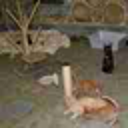

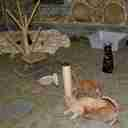

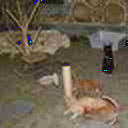

训练前噪音 33.3014 训练后噪音 33.9265 （越大越好）


In [39]:
disp(0, mean_of_train, std_of_train, X_train, y_train, train_result)

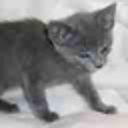

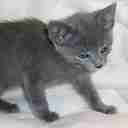

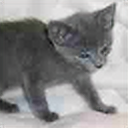

训练前噪音 36.8939 训练后噪音 37.0125 （越大越好）


In [40]:
disp(0, mean_of_train, std_of_train, X_test, y_test, test_result)